# Importing Libraries & Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.utilities import regressor_coefficients
import utils
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions definitions

In [2]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data Upload & Verification

In [3]:
# Get Data
drv_data = pd.read_csv('/Users/didi/Documents/Short Term Forecast/drv_data_ssl_full2022.csv',encoding='cp1252')
pax_data = pd.read_csv('/Users/didi/Documents/Short Term Forecast/pax_data_ssl_full2022.csv',encoding='cp1252')
eyeballs = pd.read_csv('/Users/didi/Documents/Short Term Forecast/eyeball_data_ssl_full2022.csv' ,encoding='cp1252')
burn = pd.read_csv('/Users/didi/Documents/Short Term Forecast/burn_data_ssl_full2022.csv')
holidays = pd.read_csv('/Users/didi/Documents/Short Term Forecast/SSL Central Ops - List of Holidays - holidays.csv')
paychecks = pd.read_csv('/Users/didi/Documents/Short Term Forecast/paycheck.csv')
dates = pd.read_csv('/Users/didi/Documents/Short Term Forecast/date_data.csv')
print(drv_data.info())
drv_data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83816 entries, 0 to 83815
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   current_stat_date         83816 non-null  object 
 1   year_calendar_week        83816 non-null  object 
 2   country_code              83816 non-null  object 
 3   city_id                   83816 non-null  int64  
 4   city_name                 83684 non-null  object 
 5   dfsh_cnt                  83816 non-null  int64  
 6   dfsh_online_time          38902 non-null  float64
 7   dfsh_shpd                 38902 non-null  float64
 8   retained_drv_cnt          83816 non-null  int64  
 9   retained_drv_online_time  38902 non-null  float64
 10  retained_drv_shpd         38618 non-null  float64
 11  active_drv_cnt            83816 non-null  int64  
 12  active_drv_online_time    83816 non-null  float64
 13  active_drv_shpd           83816 non-null  float64
dtypes: flo

,current_stat_date,year_calendar_week,country_code,city_id,city_name,dfsh_cnt,dfsh_online_time,dfsh_shpd,retained_drv_cnt,retained_drv_online_time,retained_drv_shpd,active_drv_cnt,active_drv_online_time,active_drv_shpd
0,2020-09-01,2020/36,MX,52260100,Ciudad Obreg¨®n,10,36.866667,3.686667,694,4847.016667,6.984174,704,4883.883333,6.937334


In [4]:
dates.head()

,date_id,date_value,year,month,month_name,day,day_of_year,weekday_name,calendar_week,formatted_date,quartal,year_quartal,year_month,year_calendar_week,weekend,weekday,period,rank
0,20200901,01/09/20,2020,9,September,1,245,Tuesday,36,01/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,2,2020/P9,1
1,20200902,02/09/20,2020,9,September,2,246,Wednesday,36,02/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,3,2020/P9,1
2,20200903,03/09/20,2020,9,September,3,247,Thursday,36,03/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,4,2020/P9,1
3,20200904,04/09/20,2020,9,September,4,248,Friday,36,04/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,5,2020/P9,1
4,20200905,05/09/20,2020,9,September,5,249,Saturday,36,05/09/20,Q3,2020/Q3,2020/09,2020/36,Weekend,6,2020/P9,1


In [5]:
pax_data.head(1)

,current_stat_date,year_calendar_week,country_code,city_name,city_id,pfc_pax_cnt,pfc_calls,pfc_cpp,retained_pax_cnt,retained_calls,retained_cpp,active_pax_cnt,active_pax_calls,active_pax_cpp,rides
0,2020-09-01,2020/36,CL,Ovalle,56580200,6,16.0,2.666667,35,61.0,1.742857,41,77,1.878049,18.0


In [6]:
holidays.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_year_calendar_week  784 non-null    object 
 1   concat                  784 non-null    object 
 2   Unnamed: 2              0 non-null      float64
 3   subregion               784 non-null    object 
 4   country_code            784 non-null    object 
 5   year                    784 non-null    int64  
 6   month                   784 non-null    int64  
 7   day                     784 non-null    int64  
 8   date_value              784 non-null    object 
 9   date_id                 784 non-null    int64  
 10  date                    784 non-null    object 
 11  weekday                 784 non-null    object 
 12  holiday_name            784 non-null    object 
dtypes: float64(1), int64(4), object(8)
memory usage: 79.8+ KB


In [7]:
holidays[holidays.country_code == 'MX'].holiday_name.unique()


array(["New Year's Day", 'Constitution Day', 'Benito Juarez Day',
       'Holy Thursday', 'Good Friday', 'Labor Day',
       'Anniversary of the Battle of Puebla', 'Independence Day',
       'Day of the Race', "All Souls' Day", 'Revolution Day',
       'Lady of Guadalupe Day', 'Christmas Day'], dtype=object)

In [8]:
paychecks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   formatted_date  1827 non-null   object
 1   paycheck_day    1827 non-null   int64 
 2   week_num        1827 non-null   int64 
 3   weekend_flag    1827 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 57.2+ KB


In [9]:
paychecks.head(20)

,formatted_date,paycheck_day,week_num,weekend_flag
0,01/01/21,1,53,0
1,02/01/21,1,53,1
2,03/01/21,1,53,1
3,04/01/21,0,2,0
4,05/01/21,0,2,0
5,06/01/21,0,2,0
6,07/01/21,0,2,0
7,08/01/21,0,2,0
8,09/01/21,0,2,1
9,10/01/21,0,2,1


In [10]:
burn = burn[burn['city_id'].notnull()]
burn.city_id = burn.city_id.apply(np.int64)
burn.pax_aqc_burn = np.where(burn.pax_aqc_burn.isna,burn.pax_aqc_burn,0)
burn.drv_acq_burn = np.where(burn.drv_acq_burn.isna,burn.drv_acq_burn,0)
burn = burn[burn.city_id != -99999]
burn= burn.assign(pax_acq_burn_pct = burn.pax_aqc_burn/ burn.gmv
                  ,drv_acq_burn_pct = burn.drv_acq_burn/ burn.gmv)
burn[burn['pax_aqc_burn'].isna()]

,city_id,current_stat_date,country_code,gmv,pax_eng_burn,pax_aqc_burn,drv_eng_burn,drv_acq_burn,pax_acq_burn_pct,drv_acq_burn_pct


# Transform Dataset

In [12]:
# Merge pax and driver data
df1 = (pax_data
        .merge(drv_data, how='left', on = ['current_stat_date','city_id','year_calendar_week', 'country_code'])
        .merge(burn, how='left', on = ['current_stat_date','city_id', 'country_code'])
        .drop(columns=['city_name_y'])
        .rename(columns = {'city_name_x':'city_name'})
    )
# Transfrom to Datetime Format
df1.current_stat_date = pd.to_datetime(df1.current_stat_date, format = '%Y-%m-%d')
df1.columns



Index(['current_stat_date', 'year_calendar_week', 'country_code', 'city_name',
       'city_id', 'pfc_pax_cnt', 'pfc_calls', 'pfc_cpp', 'retained_pax_cnt',
       'retained_calls', 'retained_cpp', 'active_pax_cnt', 'active_pax_calls',
       'active_pax_cpp', 'rides', 'dfsh_cnt', 'dfsh_online_time', 'dfsh_shpd',
       'retained_drv_cnt', 'retained_drv_online_time', 'retained_drv_shpd',
       'active_drv_cnt', 'active_drv_online_time', 'active_drv_shpd', 'gmv',
       'pax_eng_burn', 'pax_aqc_burn', 'drv_eng_burn', 'drv_acq_burn',
       'pax_acq_burn_pct', 'drv_acq_burn_pct'],
      dtype='object')

In [ ]:
df1.head()

In [546]:
dates.head()

,date_id,date_value,year,month,month_name,day,day_of_year,weekday_name,calendar_week,formatted_date,quartal,year_quartal,year_month,year_calendar_week,weekend,weekday,period,rank
0,20200901,01/09/20,2020,9,September,1,245,Tuesday,36,01/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,2,2020/P9,1
1,20200902,02/09/20,2020,9,September,2,246,Wednesday,36,02/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,3,2020/P9,1
2,20200903,03/09/20,2020,9,September,3,247,Thursday,36,03/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,4,2020/P9,1
3,20200904,04/09/20,2020,9,September,4,248,Friday,36,04/09/20,Q3,2020/Q3,2020/09,2020/36,Weekday,5,2020/P9,1
4,20200905,05/09/20,2020,9,September,5,249,Saturday,36,05/09/20,Q3,2020/Q3,2020/09,2020/36,Weekend,6,2020/P9,1


In [547]:

# Transfrom to Datetime Format and drop columns
paychecks.formatted_date = pd.to_datetime(paychecks.formatted_date, format='%d/%m/%y')
paychecks.drop(columns = ['week_num'], inplace = True)
dates.date_value = pd.to_datetime(dates.date_value,  format='%d/%m/%y')

# Final DataFrame with paycheck
master = (df1.merge(paychecks, how = 'left', left_on = 'current_stat_date', right_on = 'formatted_date')
      .drop(columns = ['year_calendar_week', 'city_name', 'formatted_date'])
      .sort_values('current_stat_date', ascending = True))




In [548]:
master['day_of_week'] = master.current_stat_date.dt.day_name()

In [549]:
col = ['day_of_week' ]
for i in col: 
      master[i] = master[i].astype('category')
master =  pd.concat((master,pd.get_dummies(master['day_of_week'], drop_first= True)), axis = 1)

# Statistical check

In [550]:
# Filters
city_id_filter = 52090100 # --> CDMX 
country_code_filter = 'MX'

# Dataframe for MX & CDMX, adding day of week
stat_df = master[(master.country_code == country_code_filter)&(master.city_id == city_id_filter)]

In [551]:
stat_df.columns

Index(['current_stat_date', 'country_code', 'city_id', 'pfc_pax_cnt',
       'pfc_calls', 'pfc_cpp', 'retained_pax_cnt', 'retained_calls',
       'retained_cpp', 'active_pax_cnt', 'active_pax_calls', 'active_pax_cpp',
       'rides', 'dfsh_cnt', 'dfsh_online_time', 'dfsh_shpd',
       'retained_drv_cnt', 'retained_drv_online_time', 'retained_drv_shpd',
       'active_drv_cnt', 'active_drv_online_time', 'active_drv_shpd', 'gmv',
       'pax_eng_burn', 'pax_aqc_burn', 'drv_eng_burn', 'drv_acq_burn',
       'pax_acq_burn_pct', 'drv_acq_burn_pct', 'paycheck_day', 'weekend_flag',
       'day_of_week', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

                                 OLS Regression Results                                
Dep. Variable:              pfc_calls   R-squared (uncentered):                   0.887
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              826.2
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                        0.00
Time:                        15:03:36   Log-Likelihood:                         -8118.1
No. Observations:                 848   AIC:                                  1.625e+04
Df Residuals:                     840   BIC:                                  1.629e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

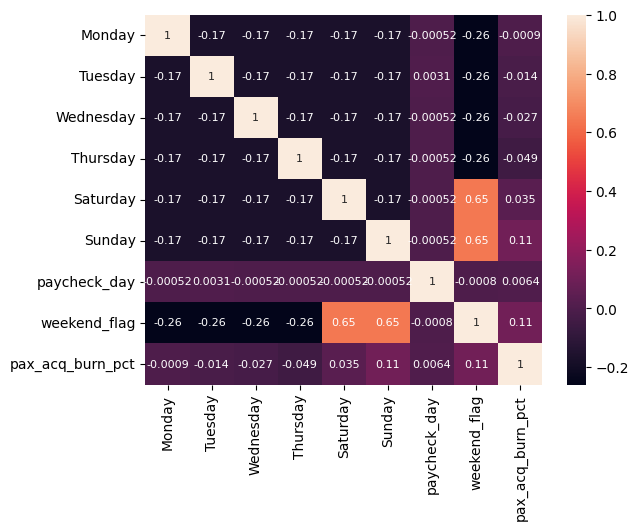

                                 OLS Regression Results                                
Dep. Variable:         retained_calls   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                              566.7
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                   2.86e-313
Time:                        15:03:36   Log-Likelihood:                         -11337.
No. Observations:                 848   AIC:                                  2.269e+04
Df Residuals:                     841   BIC:                                  2.272e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

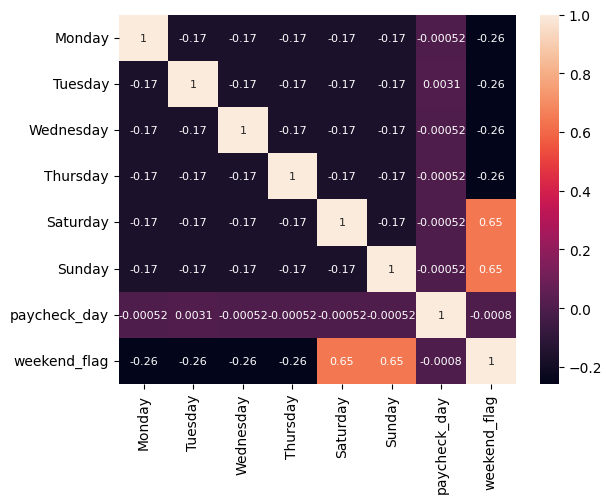

                                 OLS Regression Results                                
Dep. Variable:       dfsh_online_time   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              475.7
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                   2.26e-287
Time:                        15:03:36   Log-Likelihood:                         -6195.9
No. Observations:                 848   AIC:                                  1.241e+04
Df Residuals:                     841   BIC:                                  1.244e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

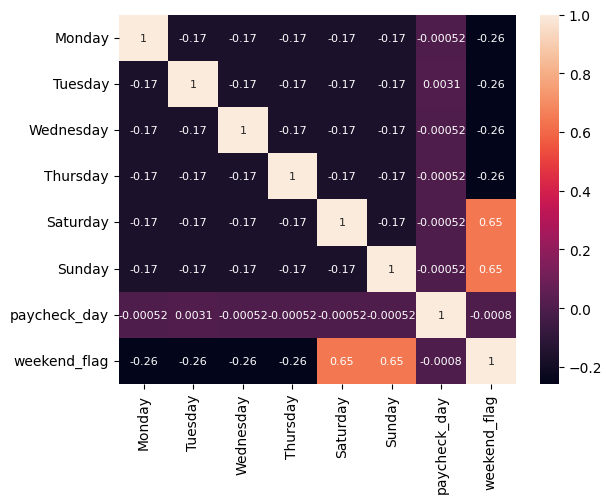

                                    OLS Regression Results                                   
Dep. Variable:     retained_drv_online_time   R-squared (uncentered):                   0.822
Model:                                  OLS   Adj. R-squared (uncentered):              0.820
Method:                       Least Squares   F-statistic:                              554.7
Date:                      Thu, 29 Dec 2022   Prob (F-statistic):                   4.60e-310
Time:                              15:03:37   Log-Likelihood:                         -11151.
No. Observations:                       848   AIC:                                  2.232e+04
Df Residuals:                           841   BIC:                                  2.235e+04
Df Model:                                 7                                                  
Covariance Type:                  nonrobust                                                  
                   coef    std err          t      P>|t|    

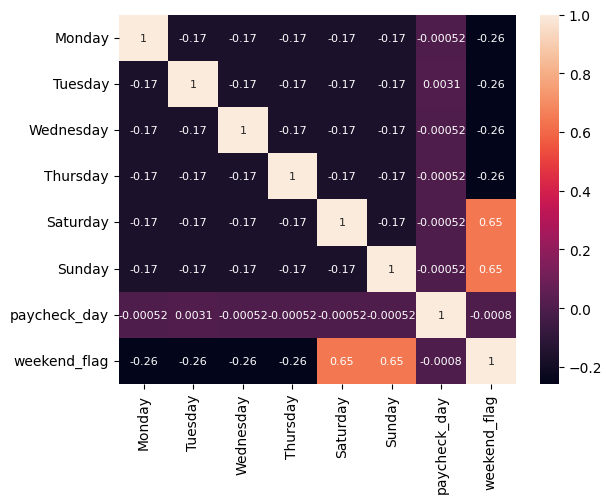

In [552]:
# Dataframe for PFC calls 
pfc_y = stat_df['pfc_calls']
pfc_x = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day', 'pax_acq_burn_pct']]
pfc_model = sm.OLS(pfc_y, pfc_x).fit()
# pfc_predictions = model.predict(x)
print(pfc_model.summary())
pfc_corr_matrix = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day', 'weekend_flag', 'pax_acq_burn_pct']].corr()
sns.heatmap(pfc_corr_matrix, annot = True,annot_kws={"size":8})
plt.show()


# Dataframe for Pax calls 
pax_y = stat_df['retained_calls']
pax_x = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day']]
pax_model = sm.OLS(pax_y, pax_x).fit()
# pax_predictions = pax_model.predict(x)
print(pax_model.summary())
pax_corr_matrix = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day', 'weekend_flag']].corr()
sns.heatmap(pax_corr_matrix, annot = True,annot_kws={"size":8})
plt.show()


# Dataframe for DFSH calls 
dfsh_y = stat_df['dfsh_online_time']
dfsh_x = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day']]
dfsh_model = sm.OLS(dfsh_y, dfsh_x).fit()
# pax_predictions = pax_model.predict(x)
print(dfsh_model.summary())
dfsh_corr_matrix = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day', 'weekend_flag']].corr()
sns.heatmap(dfsh_corr_matrix, annot = True,annot_kws={"size":8})
plt.show()

# Dataframe for Drv calls 
drv_y = stat_df['retained_drv_online_time']
drv_x = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day']]
drv_model = sm.OLS(drv_y, drv_x).fit()
# pax_predictions = pax_model.predict(x)
print(drv_model.summary())
drv_corr_matrix = stat_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday','paycheck_day', 'weekend_flag']].corr()
sns.heatmap(drv_corr_matrix, annot = True,annot_kws={"size":8})
plt.show()

# Holidays Modeling

In [553]:
# Transfrom to Datetime Format
holidays.date_value = pd.to_datetime(holidays.date_value, format='%d/%m/%y')
holidays = holidays.drop(columns = ['new_year_calendar_week', 'concat', 'Unnamed: 2', 'subregion', 'year', 'month', 'day', 'date_id', 'date',
       'weekday'])
# Holiday Dataframe
holidays = pd.DataFrame({'holiday': holidays.holiday_name, 'ds': holidays.date_value, 'lower_window': -1, 'upper_window':1, 'country_code': holidays.country_code})
holidays.head(1)

,holiday,ds,lower_window,upper_window,country_code
0,New Year's Day,2022-01-01,-1,1,MX


In [554]:
# Holiddays Datafrmae visualisation
print(list(holidays.country_code.unique()))

['MX', 'CO', 'CR', 'EC', 'DO', 'PA', 'AR', 'CL', 'PE']


# Dataset preparation for predicted variables 

In [555]:
# Filters
city_id_filter = 52090100 # --> CDMX 
country_code_filter = 'MX'

# Mater File of Predicted PAX Variables
master_pfc_df = (pd.DataFrame(
    data = master, columns=['current_stat_date', 'pfc_pax_cnt', 'paycheck_day', 'city_id','pax_acq_burn_pct', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday'])
    .rename(columns = {'current_stat_date': 'ds','pfc_pax_cnt': 'y' }))
master_pfc_df = master_pfc_df[(master_pfc_df.city_id == city_id_filter)].drop(columns = 'city_id')

master_pax_df = (pd.DataFrame(
    data = master, columns=['current_stat_date', 'retained_pax_cnt', 'paycheck_day', 'city_id', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday'])
    .rename(columns = {'current_stat_date': 'ds','retained_pax_cnt': 'y' }))
master_pax_df = master_pax_df[(master_pax_df.city_id == city_id_filter)].drop(columns = 'city_id')

# Mater File of Predicted DRV Variables
master_dfsh_df = (pd.DataFrame(
    data = master, columns=['current_stat_date', 'dfsh_cnt', 'paycheck_day', 'city_id', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday'])
    .rename(columns = {'current_stat_date': 'ds','dfsh_cnt': 'y' }))
master_dfsh_df = master_dfsh_df[(master_dfsh_df.city_id == city_id_filter)].drop(columns = 'city_id')

master_drv_df = (pd.DataFrame(
    data = master, columns=['current_stat_date', 'retained_drv_cnt', 'paycheck_day', 'city_id', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday'])
    .rename(columns = {'current_stat_date': 'ds','retained_drv_cnt': 'y' }))
master_drv_df = master_drv_df[(master_drv_df.city_id == city_id_filter)].drop(columns = 'city_id')

# Master Holidays File
master_holidays = holidays[holidays.country_code == country_code_filter].drop(columns = 'country_code')

# 

# Training and test set

In [556]:
# Test Days
testdays = 93

# Slicing Datasets for PAX
pfc_training_set = master_pfc_df.iloc[:-testdays,:]
pfc_test_set = master_pfc_df.iloc[-testdays:,:]

pax_training_set = master_pax_df.iloc[:-testdays,:]
pax_test_set = master_pax_df.iloc[-testdays:,:]

# Slicing Datasets for DRV
dfsh_training_set = master_dfsh_df.iloc[:-testdays,:]
dfsh_test_set = master_dfsh_df.iloc[-testdays:,:]

drv_training_set = master_drv_df.iloc[:-testdays,:]
drv_test_set = master_drv_df.iloc[-testdays:,:]


# Forecasting Models

In [557]:
# Pax Prediction Models
pfc_m = Prophet(growth = 'linear'
                , yearly_seasonality= True
                , weekly_seasonality= True
                , daily_seasonality= True
                , seasonality_mode= 'multiplicative'
                , seasonality_prior_scale= 10
                , holidays_prior_scale = 10
                , changepoint_prior_scale= 0.05
                , holidays = master_holidays )
pfc_m.add_regressor('pax_acq_burn_pct')
pfc_m.add_regressor('paycheck_day')
pfc_m.add_regressor('Monday')
pfc_m.add_regressor('Tuesday')
pfc_m.add_regressor('Wednesday')
pfc_m.add_regressor('Thursday')
pfc_m.add_regressor('Saturday')
pfc_m.add_regressor('Sunday') # Add weather
pfc_m.fit(pfc_training_set)

pax_m = Prophet(growth = 'linear'
                , yearly_seasonality= True
                , weekly_seasonality= True
                , daily_seasonality= True
                , seasonality_mode= 'multiplicative'
                , seasonality_prior_scale=10
                , holidays_prior_scale = 10
                , changepoint_prior_scale= 0.05
                , holidays = master_holidays )
pax_m.add_regressor('paycheck_day')
pax_m.add_regressor('Monday')
pax_m.add_regressor('Tuesday')
pax_m.add_regressor('Wednesday')
pax_m.add_regressor('Thursday')
pax_m.add_regressor('Saturday')
pax_m.add_regressor('Sunday')
pax_m.fit(pax_training_set)

# Drv Prediction Models
dfsh_m = Prophet(growth = 'linear'
                , yearly_seasonality= True
                , weekly_seasonality= True
                , daily_seasonality= True
                , seasonality_mode= 'multiplicative'
                , seasonality_prior_scale= 10
                , holidays_prior_scale = 10
                , changepoint_prior_scale= 0.05
                , holidays = master_holidays )
dfsh_m.add_regressor('paycheck_day')
dfsh_m.add_regressor('Monday')
dfsh_m.add_regressor('Tuesday')
dfsh_m.add_regressor('Wednesday')
dfsh_m.add_regressor('Thursday')
dfsh_m.add_regressor('Saturday')
dfsh_m.add_regressor('Sunday')
dfsh_m.fit(dfsh_training_set)

drv_m = Prophet(growth = 'linear'
                , yearly_seasonality= True
                , weekly_seasonality= True
                , daily_seasonality= True
                , seasonality_mode= 'multiplicative'
                , seasonality_prior_scale=10
                , holidays_prior_scale = 10
                , changepoint_prior_scale= 0.05
                , holidays = master_holidays )
drv_m.add_regressor('paycheck_day')
drv_m.add_regressor('Monday')
drv_m.add_regressor('Tuesday')
drv_m.add_regressor('Wednesday')
drv_m.add_regressor('Thursday')
drv_m.add_regressor('Saturday')
drv_m.add_regressor('Sunday')
drv_m.fit(drv_training_set)

15:03:37 - cmdstanpy - INFO - Chain [1] start processing
15:03:37 - cmdstanpy - INFO - Chain [1] done processing
15:03:37 - cmdstanpy - INFO - Chain [1] start processing
15:03:38 - cmdstanpy - INFO - Chain [1] done processing
15:03:38 - cmdstanpy - INFO - Chain [1] start processing
15:03:38 - cmdstanpy - INFO - Chain [1] done processing
15:03:38 - cmdstanpy - INFO - Chain [1] start processing
15:03:39 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [558]:
# Making Future DF for Pax
pfc_future = pfc_m.make_future_dataframe(periods = len(pfc_test_set), freq = 'D')
pax_future = pax_m.make_future_dataframe(periods = len(pax_test_set), freq = 'D')

# Making Future DF for DRV
dfsh_future = dfsh_m.make_future_dataframe(periods = len(dfsh_test_set), freq = 'D')
drv_future = drv_m.make_future_dataframe(periods = len(drv_test_set), freq = 'D')

In [559]:
# Merging pax future DF with regressors
pfc_future = pfc_future.merge(master_pfc_df, how = 'left', on = 'ds')
pax_future = pax_future.merge(master_pax_df, how = 'left', on = 'ds')

# Merging drv future DF with regressors
dfsh_future = dfsh_future.merge(master_dfsh_df, how = 'left', on = 'ds')
drv_future = drv_future.merge(master_drv_df, how = 'left', on = 'ds')

In [560]:
# Forecast for Pax
pfc_forecast = pfc_m.predict(pfc_future)
pax_forecast = pax_m.predict(pax_future)

# Forecast for Drv
dfsh_forecast = dfsh_m.predict(dfsh_future)
drv_forecast = drv_m.predict(drv_future)

# Visualize

Text(0.5, 1.0, 'Retained DRV Prediction')

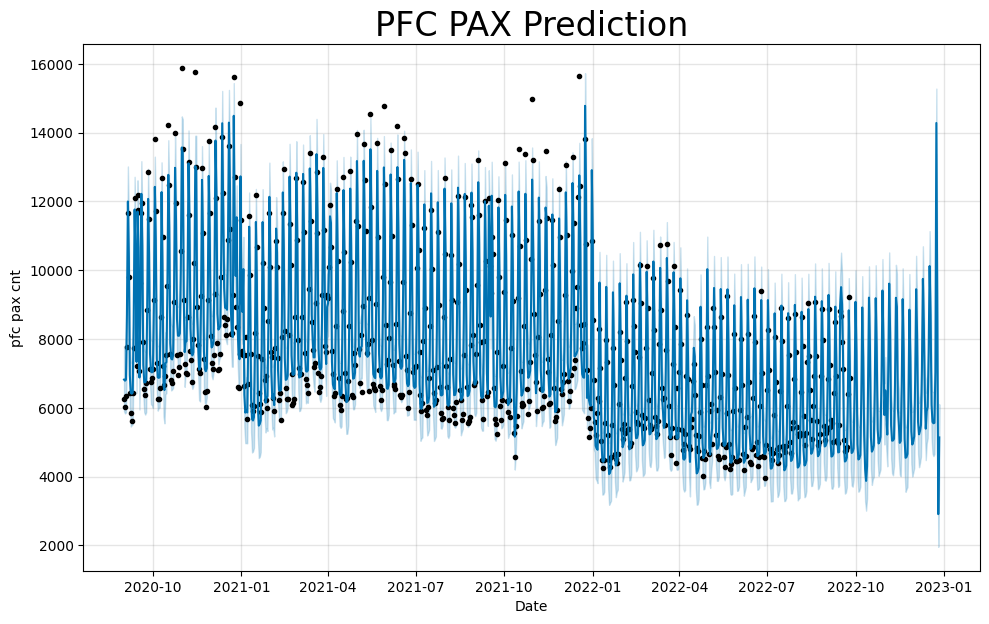

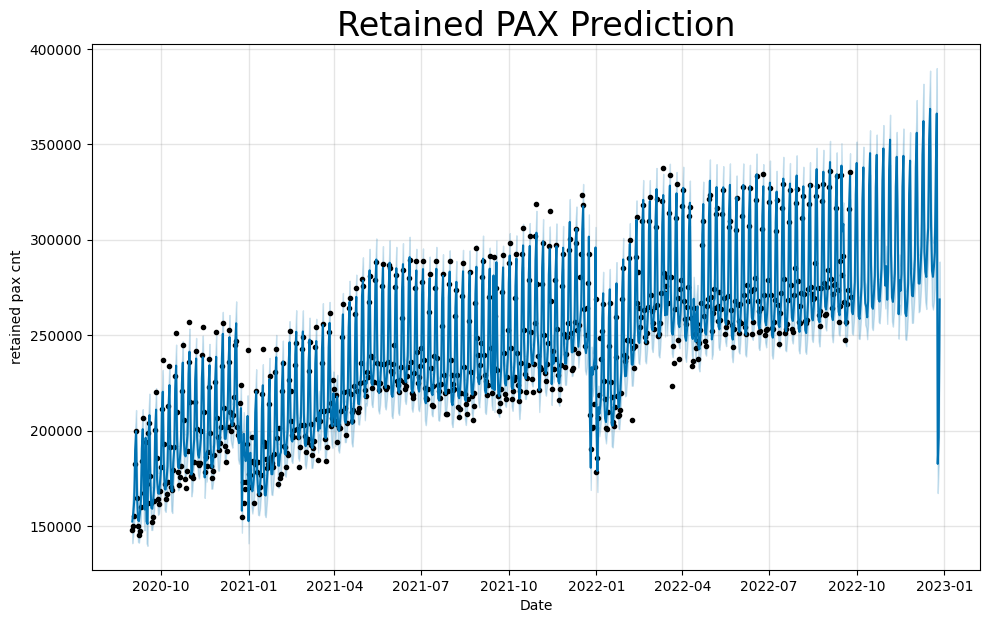

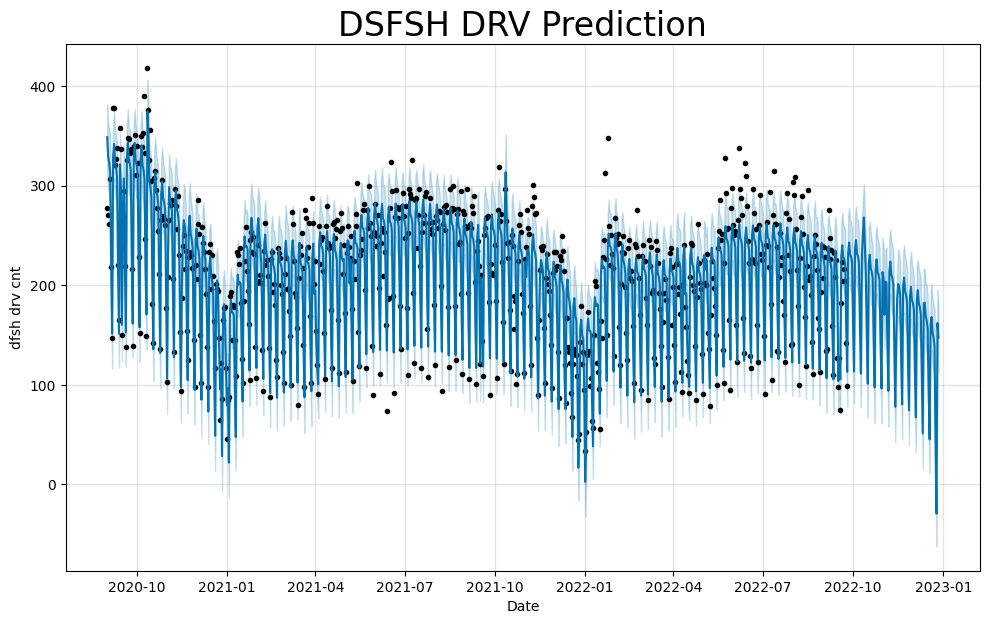

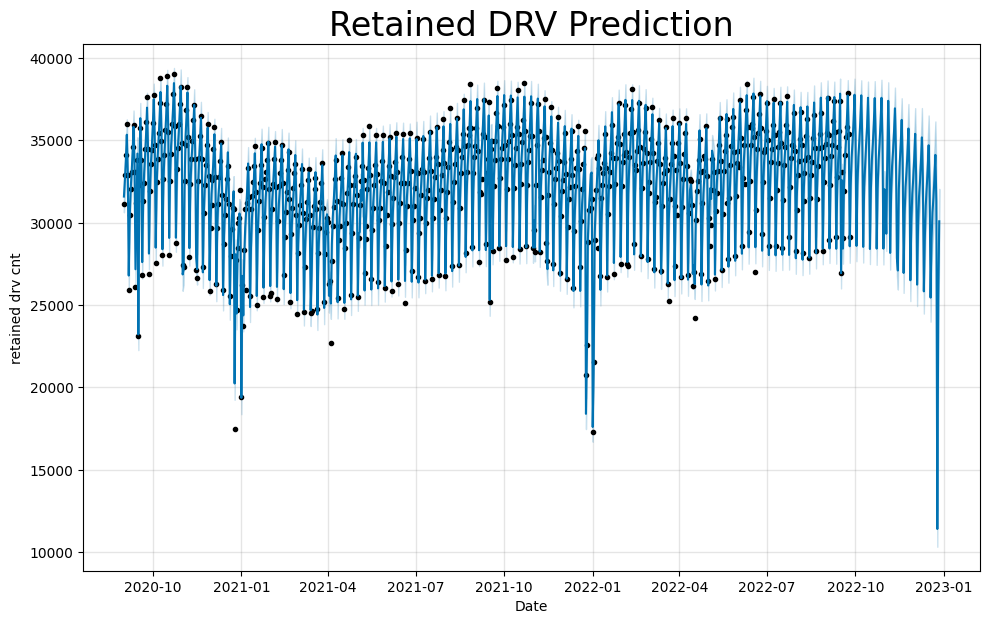

In [561]:
# Visualize forecast for Pax
pfc_fig = pfc_m.plot(pfc_forecast, xlabel='Date', ylabel='pfc pax cnt');
pfc_ax = pfc_fig.gca()
pfc_ax.set_title("PFC PAX Prediction", size=24)

pax_fig = pax_m.plot(pax_forecast, xlabel='Date', ylabel='retained pax cnt');
pax_ax = pax_fig.gca()
pax_ax.set_title("Retained PAX Prediction", size=24)

# Visualize forecast for Drv
dfsh_fig = dfsh_m.plot(dfsh_forecast, xlabel='Date', ylabel='dfsh drv cnt');
dfsh_ax = dfsh_fig.gca()
dfsh_ax.set_title("DSFSH DRV Prediction", size=24)

drv_fig = drv_m.plot(drv_forecast, xlabel='Date', ylabel='retained drv cnt');
drv_ax = drv_fig.gca()
drv_ax.set_title("Retained DRV Prediction", size=24)

Text(0.5, 1.0, 'Retained DRV Components')

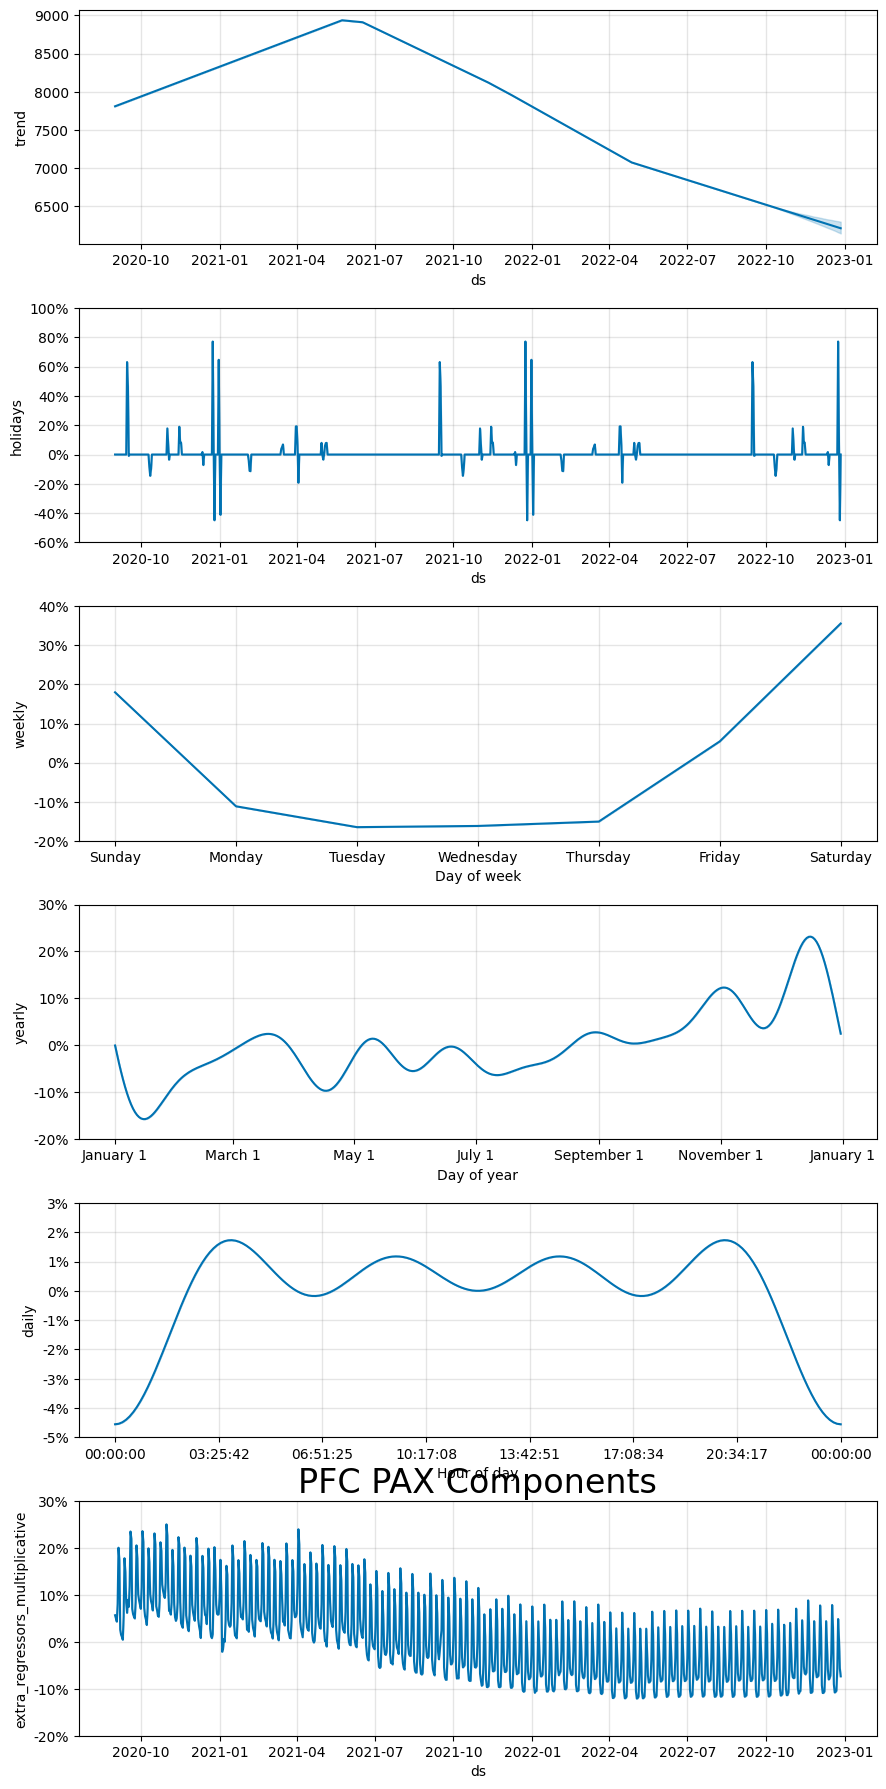

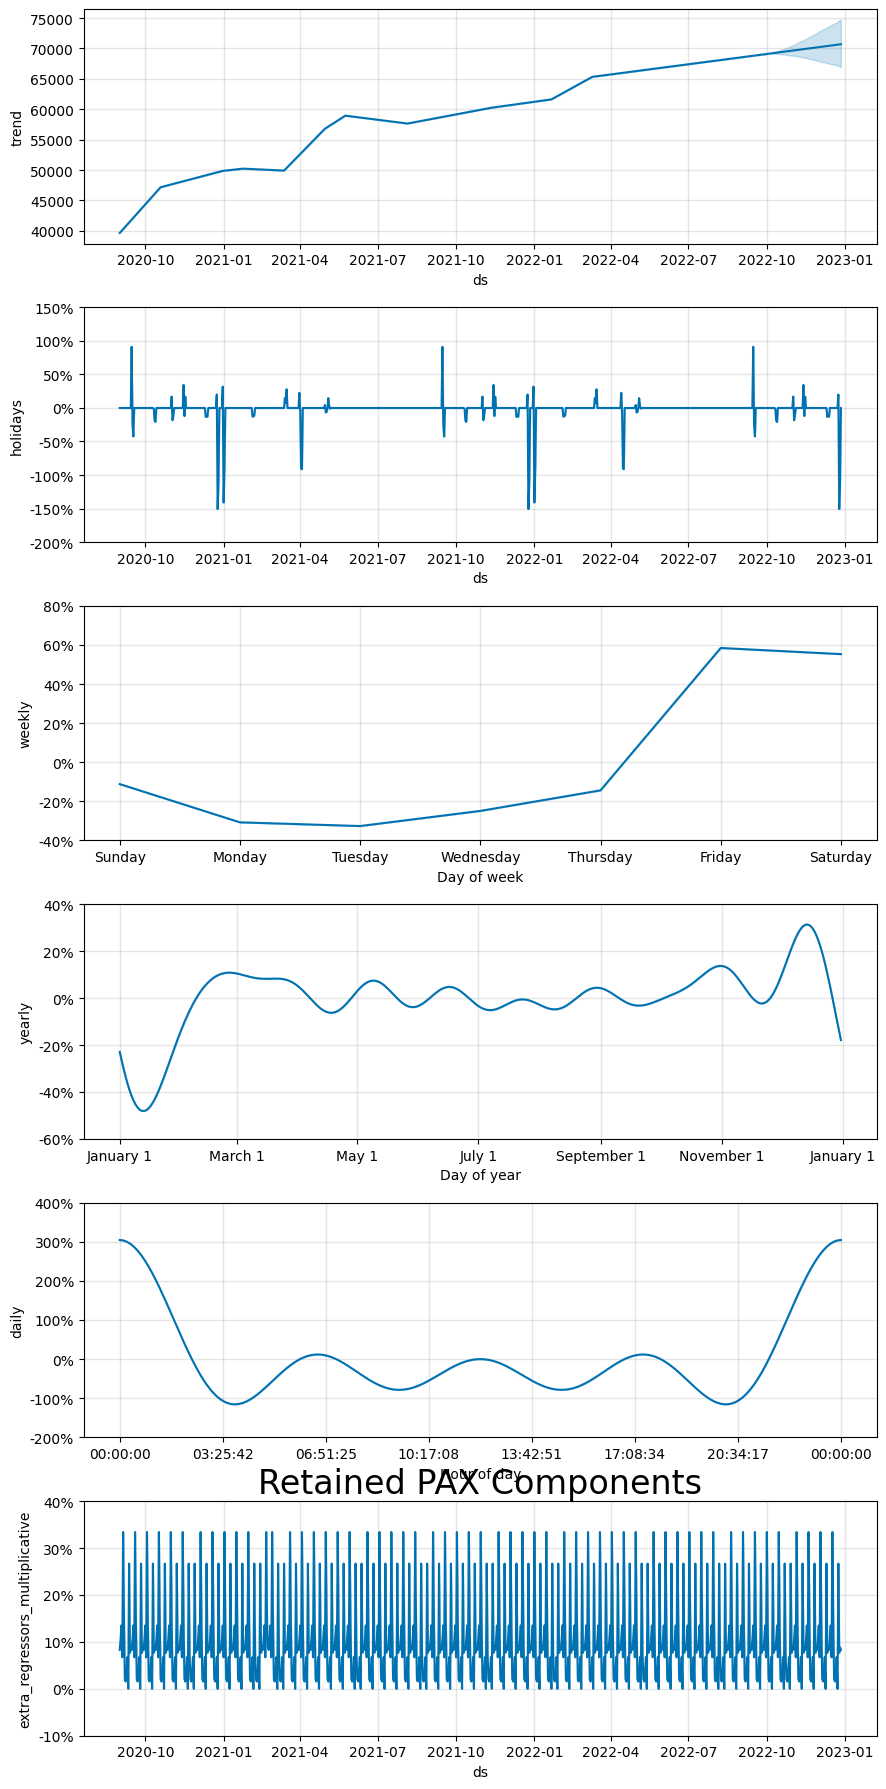

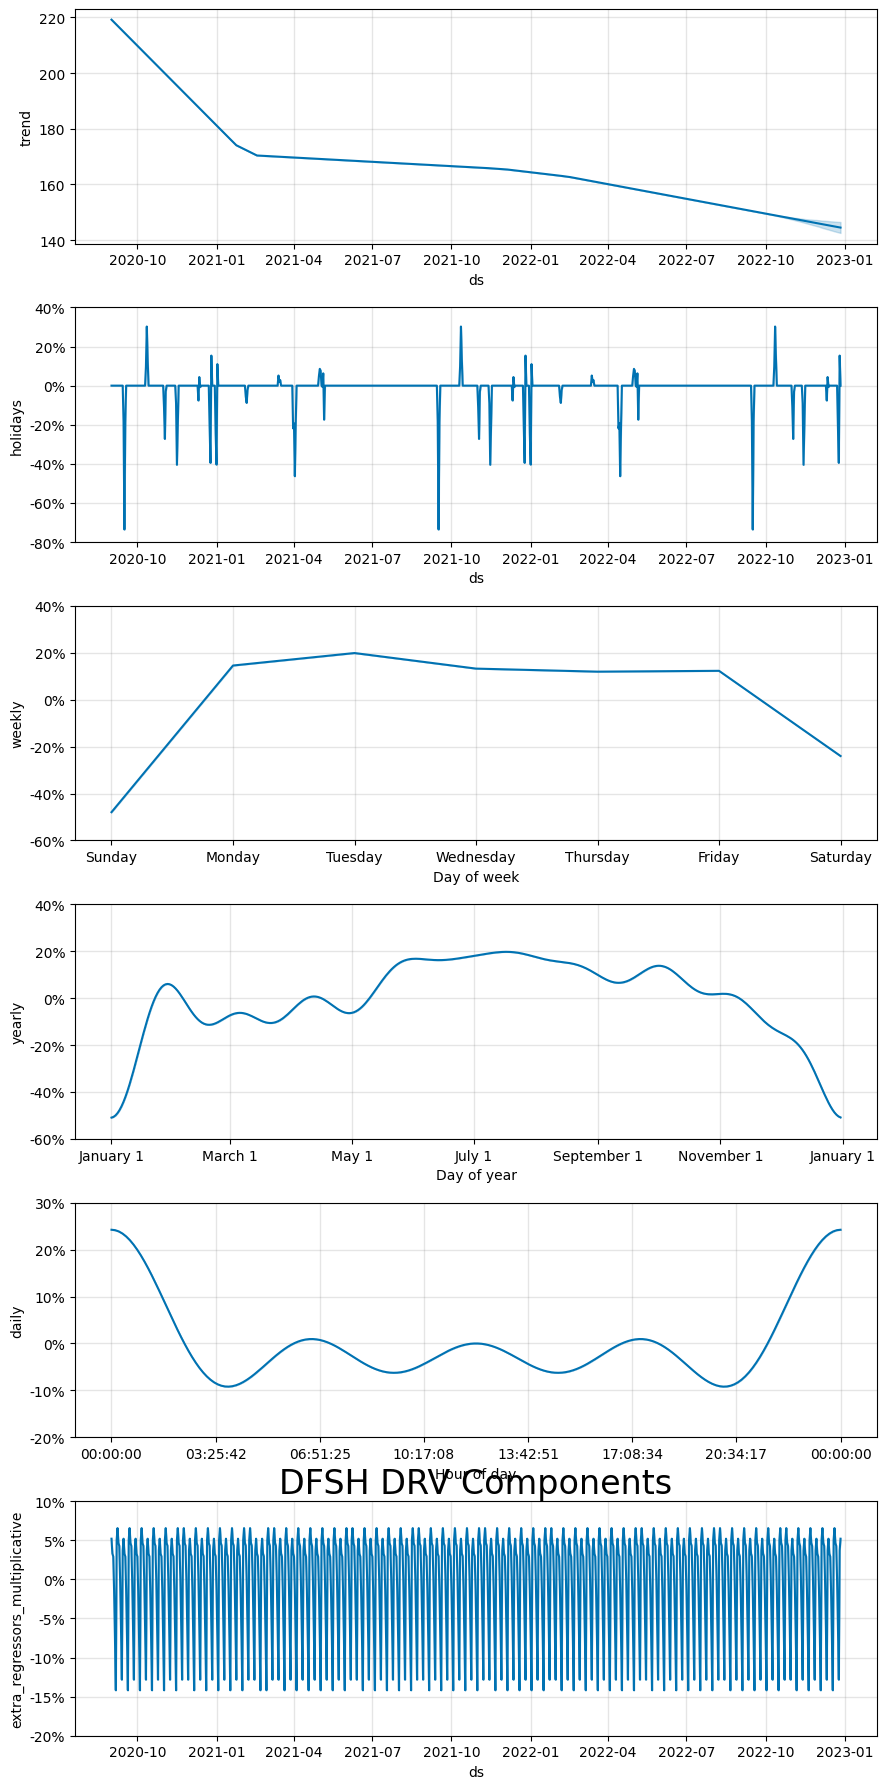

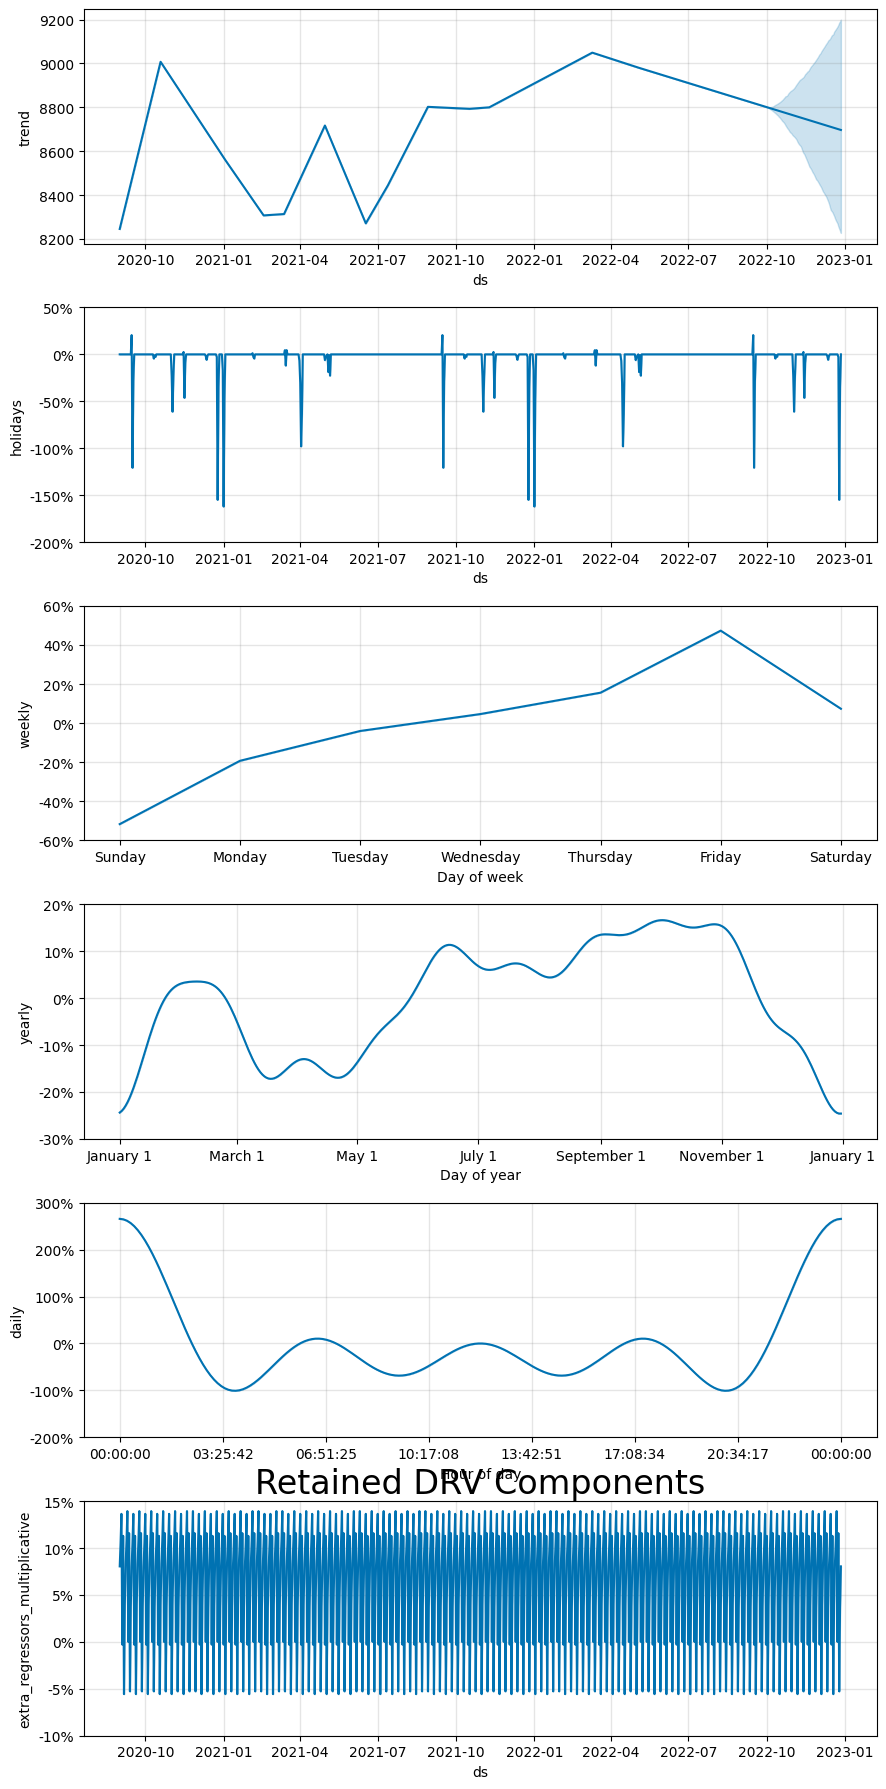

In [562]:
# Plot components PAX
pfc_fig2 = pfc_m.plot_components(pfc_forecast); 
pfc_ax2 = pfc_fig2.gca()
pfc_ax2.set_title("PFC PAX Components", size=24)

pax_fig2 = pax_m.plot_components(pax_forecast); 
pax_ax2 = pax_fig2.gca()
pax_ax2.set_title("Retained PAX Components", size=24)

# Plot components DRV
dfsh_fig2 = dfsh_m.plot_components(dfsh_forecast); 
dfsh_ax2 = dfsh_fig2.gca()
dfsh_ax2.set_title("DFSH DRV Components", size=24)

drv_fig2 = drv_m.plot_components(drv_forecast); 
drv_ax2 = drv_fig2.gca()
drv_ax2.set_title("Retained DRV Components", size=24)


# Model Assessment

In [563]:
# Predictions for PAX
pfc_predictions_prophet = pfc_forecast.yhat[-testdays:].rename('Prophet PFC')
pfc_predictions_prophet.index = pfc_test_set['ds']

pax_predictions_prophet = pax_forecast.yhat[-testdays:].rename('Prophet Ret PAX')
pax_predictions_prophet.index = pax_test_set['ds']

# Predictions for PAX
dfsh_predictions_prophet = dfsh_forecast.yhat[-testdays:].rename('Prophet DFSH')
dfsh_predictions_prophet.index = dfsh_test_set['ds']

drv_predictions_prophet = drv_forecast.yhat[-testdays:].rename('Prophet Ret DRV')
drv_predictions_prophet.index = drv_test_set['ds']

In [564]:
# MAE, RMSE and MAPE for PAX
print('Test vs Prediction PFC MAE ',round(mean_absolute_error(pfc_test_set['y'],pfc_predictions_prophet),0))
print('Test vs Prediction PFC RMSE ',round(np.sqrt(mean_squared_error(pfc_test_set['y'], pfc_predictions_prophet)),0))
print('Test vs Prediction PFC MAPE ',MAPE(pfc_test_set['y'], pfc_predictions_prophet), '\n')

print('Test vs Prediction PAX MAE ',round(mean_absolute_error(pax_test_set['y'],pax_predictions_prophet),0))
print('Test vs Prediction PAX RMSE ',round(np.sqrt(mean_squared_error(pax_test_set['y'], pax_predictions_prophet)),0))
print('Test vs Prediction PAX MAPE ',MAPE(pax_test_set['y'], pax_predictions_prophet), '\n')

# MAE, RMSE and MAPE for DRV
print('Test vs Prediction DFSH MAE ',round(mean_absolute_error(dfsh_test_set['y'],dfsh_predictions_prophet),0))
print('Test vs Prediction DFSH RMSE ',round(np.sqrt(mean_squared_error(dfsh_test_set['y'], dfsh_predictions_prophet)),0))
print('Test vs Prediction DFSH MAPE ',MAPE(dfsh_test_set['y'], dfsh_predictions_prophet), '\n')

print('Test vs Prediction DRV MAE ',round(mean_absolute_error(drv_test_set['y'],drv_predictions_prophet),0))
print('Test vs Prediction DRV RMSE ',round(np.sqrt(mean_squared_error(drv_test_set['y'], drv_predictions_prophet)),0))
print('Test vs Prediction DRV MAPE ',MAPE(drv_test_set['y'], drv_predictions_prophet), '\n')

Test vs Prediction PFC MAE  619.0
Test vs Prediction PFC RMSE  810.0
Test vs Prediction PFC MAPE  9.089587412158732 

Test vs Prediction PAX MAE  15305.0
Test vs Prediction PAX RMSE  19233.0
Test vs Prediction PAX MAPE  5.606430263746449 

Test vs Prediction DFSH MAE  25.0
Test vs Prediction DFSH RMSE  33.0
Test vs Prediction DFSH MAPE  16.83837304166693 

Test vs Prediction DRV MAE  784.0
Test vs Prediction DRV RMSE  1251.0
Test vs Prediction DRV MAPE  2.6437676220212256 



# Cross Validation

In [565]:
# Cross Validation PAX
pfc_cv = cross_validation(pfc_m, horizon = '31 days', initial = '486 days', parallel= 'processes')
pfc_cv.head()

pax_cv = cross_validation(pax_m, horizon = '31 days', initial = '486 days', parallel= 'processes')
pax_cv.head()

# Cross Validation DRV
dfsh_cv = cross_validation(dfsh_m, horizon = '31 days', initial = '486 days', parallel= 'processes')
dfsh_cv.head()

drv_cv = cross_validation(drv_m, horizon = '31 days', initial = '486 days', parallel= 'processes')
drv_cv.head()

# Errors from Cross Validation PAX
print('CV PFC MAE ',round(mean_absolute_error(pfc_cv['y'],pfc_cv['yhat']),0))
print('CV PFC RMSE ',round(np.sqrt(mean_squared_error(pfc_cv['y'], pfc_cv['yhat'])),0))
print('CV PFC MAPE ',MAPE(pfc_cv['y'], pfc_cv['yhat']), '\n')

print('CV PAX MAE ',round(mean_absolute_error(pax_cv['y'],pax_cv['yhat']),0))
print('CV PAX RMSE ',round(np.sqrt(mean_squared_error(pax_cv['y'], pax_cv['yhat'])),0))
print('CV PAX MAPE ',MAPE(pax_cv['y'], pax_cv['yhat']), '\n')

# Errors from Cross Validation PAX
print('CV DFSH MAE ',round(mean_absolute_error(dfsh_cv['y'],dfsh_cv['yhat']),0))
print('CV DFSH RMSE ',round(np.sqrt(mean_squared_error(dfsh_cv['y'], dfsh_cv['yhat'])),0))
print('CV DFSH MAPE ',MAPE(dfsh_cv['y'], dfsh_cv['yhat']), '\n')

print('CV DRV MAE ',round(mean_absolute_error(drv_cv['y'],drv_cv['yhat']),0))
print('CV DRV RMSE ',round(np.sqrt(mean_squared_error(drv_cv['y'], drv_cv['yhat'])),0))
print('CV DRV MAPE ',MAPE(drv_cv['y'], drv_cv['yhat']))

15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:48 - cmdstanpy - INFO - Chain [1] start processing
15:03:48 - cmdstanpy - INFO - Chain [1]

CV PFC MAE  769.0
CV PFC RMSE  982.0
CV PFC MAPE  12.518838869421192 

CV PAX MAE  13764.0
CV PAX RMSE  17827.0
CV PAX MAPE  5.084085578772131 

CV DFSH MAE  32.0
CV DFSH RMSE  40.0
CV DFSH MAPE  17.018706059381326 

CV DRV MAE  1177.0
CV DRV RMSE  1545.0
CV DRV MAPE  3.6306200644532556


In [566]:
# Perfomance metrics for pax
pfc_performance = performance_metrics(pfc_cv)
print('pfc performance ','\n ',pfc_performance.tail(),'\n ' )
pax_performance = performance_metrics(pax_cv)
print('pax performance ','\n ',pax_performance.tail(),'\n ')

# Perfomance metrics for drv
dfsh_performance = performance_metrics(dfsh_cv)
print('dfsh performance ','\n ',dfsh_performance.tail(),'\n ' )
drv_performance = performance_metrics(drv_cv)
print('drv performance ','\n ',drv_performance.tail())

pfc performance  
              horizon           mse         rmse         mae      mape  \
51 29 days 00:00:00  9.773051e+05   988.587438  814.126927  0.132930   
52 29 days 12:00:00  1.009140e+06  1004.559799  808.099162  0.131806   
53 30 days 00:00:00  1.010420e+06  1005.196406  801.432122  0.127799   
54 30 days 12:00:00  1.041890e+06  1020.729956  821.554934  0.130980   
55 31 days 00:00:00  1.046544e+06  1023.007253  811.069369  0.130069   

       mdape     smape  coverage  
51  0.123517  0.143411  0.586735  
52  0.118147  0.142156  0.622449  
53  0.092298  0.137970  0.645408  
54  0.091012  0.142333  0.663265  
55  0.089293  0.140597  0.647959   
 
pax performance  
              horizon           mse          rmse           mae      mape  \
51 29 days 00:00:00  3.093016e+08  17586.971936  14891.042288  0.054513   
52 29 days 12:00:00  3.518424e+08  18757.463489  15467.875356  0.056246   
53 30 days 00:00:00  3.681680e+08  19187.704522  15929.937536  0.057309   
54 30 days 12:

# Hyperparameter Tuning

In [567]:
# Parameter Grid
param_grid = {
    'seasonality_prior_scale': [50,60,70,80]
    , 'changepoint_prior_scale': [0.05,0.1,0.2,0.3]
    , 'holidays_prior_scale':[10,20,30]
    }
grid = ParameterGrid(param_grid)
list(grid)

[{'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_prior_scale': 50},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_prior_scale': 60},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_prior_scale': 70},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_prior_scale': 80},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_prior_scale': 50},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_prior_scale': 60},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_prior_scale': 70},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_prior_scale': 80},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 30,
  'seasonality_prior_scale': 50},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 30,
  'seasonality_prior_scale': 60},
 {'changep

In [568]:
# Hyperparameter tuning PFC
pfc_mape = []
for params in grid: 
    #build model
    pfc_m = (Prophet(
        growth = 'linear'
        , yearly_seasonality = True
        , weekly_seasonality = True
        , daily_seasonality = True
        , seasonality_mode = 'multiplicative'
        , holidays = master_holidays
        , seasonality_prior_scale = params['seasonality_prior_scale']
        , holidays_prior_scale = params['holidays_prior_scale']
        , changepoint_prior_scale=  params['changepoint_prior_scale']
        )
    )
    pfc_m.add_regressor('pax_acq_burn_pct')
    pfc_m.add_regressor('paycheck_day')
    pfc_m.add_regressor('Monday')
    pfc_m.add_regressor('Tuesday')
    pfc_m.add_regressor('Wednesday')
    pfc_m.add_regressor('Thursday')
    pfc_m.add_regressor('Saturday')
    pfc_m.add_regressor('Sunday')
    pfc_m.fit(pfc_training_set)
    #cross-validation
    pfc_cv = cross_validation(pfc_m, horizon = '90 days', initial = '540 days', parallel= 'processes')
    #gather results
    pfc_error = MAPE(pfc_cv['y'], pfc_cv['yhat'])
    
    pfc_mape.append(pfc_error)

15:04:02 - cmdstanpy - INFO - Chain [1] start processing
15:04:02 - cmdstanpy - INFO - Chain [1] done processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] done processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] done processing
15:04:03 - cmdstanpy - INFO - Chain [1] done processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:04 - cmdstanpy - INFO - Chain [1] done processing
15:04:04 - cmdstanpy - INFO - Chain [1] done processing
15:04:04 - cmdstanpy - INFO - Chain [1] done processing
15:04:04 - cmdstanpy - INFO - Chain [1] done processing
15:04:04 - cmdstanpy - INFO - Chain [1]

In [569]:
# Hyperparameter tuning Retained Pax
pax_mape = []
for params in grid: 
    #build model
    pax_m = (Prophet(
        growth = 'linear'
        , yearly_seasonality = True
        , weekly_seasonality = True
        , daily_seasonality = True
        , seasonality_mode = 'multiplicative'
        , holidays = master_holidays
        , seasonality_prior_scale = params['seasonality_prior_scale']
        , holidays_prior_scale = params['holidays_prior_scale']
        , changepoint_prior_scale=  params['changepoint_prior_scale']
        )
    )
    pax_m.add_regressor('paycheck_day')
    pax_m.add_regressor('Monday')
    pax_m.add_regressor('Tuesday')
    pax_m.add_regressor('Wednesday')
    pax_m.add_regressor('Thursday')
    pax_m.add_regressor('Saturday')
    pax_m.add_regressor('Sunday')
    pax_m.fit(pax_training_set)
    #cross-validation
    pax_cv = cross_validation(pax_m, horizon = '31 days', initial = '540 days', parallel= 'processes')
    #gather results
    pax_error = MAPE(pax_cv['y'], pax_cv['yhat'])
    
    pax_mape.append(pax_error)

15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:42 - cmdstanpy - INFO - Chain [1] done processing
15:08:43 - cmdstanpy - INFO - Chain [1] start processing
15:08:43 - cmdstanpy - INFO - Chain [1] start processing
15:08:43 - cmdstanpy - INFO - Chain [1] start processing
15:08:43 - cmdstanpy - INFO - Chain [1] start processing
15:08:43 - cmdstanpy - INFO - Chain [1] start processing
15:08:43 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - INFO - Chain [1

In [570]:
# Hyperparameter tuning DFSH
dfsh_mape = []
for params in grid: 
    #build model
    dfsh_m = (Prophet(
        growth = 'linear'
        , yearly_seasonality = True
        , weekly_seasonality = True
        , daily_seasonality = True
        , seasonality_mode = 'multiplicative'
        , holidays = master_holidays
        , seasonality_prior_scale = params['seasonality_prior_scale']
        , holidays_prior_scale = params['holidays_prior_scale']
        , changepoint_prior_scale=  params['changepoint_prior_scale']
        )
    )
    dfsh_m.add_regressor('paycheck_day')
    dfsh_m.add_regressor('Monday')
    dfsh_m.add_regressor('Tuesday')
    dfsh_m.add_regressor('Wednesday')
    dfsh_m.add_regressor('Thursday')
    dfsh_m.add_regressor('Saturday')
    dfsh_m.add_regressor('Sunday')
    dfsh_m.fit(dfsh_training_set)
    #cross-validation
    dfsh_cv = cross_validation(dfsh_m, horizon = '31 days', initial = '540 days', parallel= 'processes')
    #gather results
    dfsh_error = MAPE(dfsh_cv['y'], dfsh_cv['yhat'])
    
    dfsh_mape.append(dfsh_error)

15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:00 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1]

In [571]:
# Hyperparameter tuning Retained Drv
drv_mape = []
for params in grid: 
    #build model
    drv_m = (Prophet(
        growth = 'linear'
        , yearly_seasonality = True
        , weekly_seasonality = True
        , daily_seasonality = True
        , seasonality_mode = 'multiplicative'
        , holidays = master_holidays
        , seasonality_prior_scale = params['seasonality_prior_scale']
        , holidays_prior_scale = params['holidays_prior_scale']
        , changepoint_prior_scale=  params['changepoint_prior_scale']
        )
    )
    drv_m.add_regressor('paycheck_day')
    drv_m.add_regressor('Monday')
    drv_m.add_regressor('Tuesday')
    drv_m.add_regressor('Wednesday')
    drv_m.add_regressor('Thursday')
    drv_m.add_regressor('Saturday')
    drv_m.add_regressor('Sunday')
    drv_m.fit(drv_training_set)
    #cross-validation
    drv_cv = cross_validation(drv_m, horizon = '31 days', initial = '540 days', parallel= 'processes')
    #gather results
    drv_error = MAPE(drv_cv['y'], drv_cv['yhat'])
    
    drv_mape.append(drv_error)

15:19:00 - cmdstanpy - INFO - Chain [1] start processing
15:19:01 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1]

In [572]:
# best parameters pax
pfc_best_params = grid[np.argmin(pfc_mape)]
print(pfc_best_params)

pax_best_params = grid[np.argmin(pax_mape)]
print(pax_best_params)

# best parameters drv
dfsh_best_params = grid[np.argmin(dfsh_mape)]
print(dfsh_best_params)

drv_best_params = grid[np.argmin(drv_mape)]
print(drv_best_params)

print(grid)

{'seasonality_prior_scale': 60, 'holidays_prior_scale': 30, 'changepoint_prior_scale': 0.1}
{'seasonality_prior_scale': 80, 'holidays_prior_scale': 20, 'changepoint_prior_scale': 0.1}
{'seasonality_prior_scale': 60, 'holidays_prior_scale': 20, 'changepoint_prior_scale': 0.1}
{'seasonality_prior_scale': 60, 'holidays_prior_scale': 10, 'changepoint_prior_scale': 0.2}


# Final Prophet Model

In [573]:
# PAX Final models
pfc_m = Prophet(growth = 'linear'
            , yearly_seasonality = True
            , weekly_seasonality = True
            , daily_seasonality = True
            , seasonality_mode = 'multiplicative'
            , seasonality_prior_scale = pfc_best_params['seasonality_prior_scale']
            , holidays_prior_scale = pfc_best_params['holidays_prior_scale']
            , holidays = master_holidays
            , changepoint_prior_scale =  pfc_best_params['changepoint_prior_scale'])
pfc_m.add_regressor('pax_acq_burn_pct')
pfc_m.add_regressor('paycheck_day')
pfc_m.add_regressor('Monday')
pfc_m.add_regressor('Tuesday')
pfc_m.add_regressor('Wednesday')
pfc_m.add_regressor('Thursday')
pfc_m.add_regressor('Saturday')
pfc_m.add_regressor('Sunday')
pfc_m.fit(pfc_training_set)

pax_m = Prophet(growth = 'linear'
            , yearly_seasonality = True
            , weekly_seasonality = True
            , daily_seasonality = True
            , seasonality_mode = 'multiplicative'
            , seasonality_prior_scale = pax_best_params['seasonality_prior_scale']
            , holidays_prior_scale = pax_best_params['holidays_prior_scale']
            , holidays = master_holidays
            , changepoint_prior_scale =  pax_best_params['changepoint_prior_scale'])
pax_m.add_regressor('paycheck_day')
pax_m.add_regressor('Monday')
pax_m.add_regressor('Tuesday')
pax_m.add_regressor('Wednesday')
pax_m.add_regressor('Thursday')
pax_m.add_regressor('Saturday')
pax_m.add_regressor('Sunday')
pax_m.fit(pax_training_set)

# DRV Final models
dfsh_m = Prophet(growth = 'linear'
            , yearly_seasonality = True
            , weekly_seasonality = True
            , daily_seasonality = True
            , seasonality_mode = 'multiplicative'
            , seasonality_prior_scale = dfsh_best_params['seasonality_prior_scale']
            , holidays_prior_scale = dfsh_best_params['holidays_prior_scale']
            , holidays = master_holidays
            , changepoint_prior_scale =  dfsh_best_params['changepoint_prior_scale'])
dfsh_m.add_regressor('paycheck_day')
dfsh_m.add_regressor('Monday')
dfsh_m.add_regressor('Tuesday')
dfsh_m.add_regressor('Wednesday')
dfsh_m.add_regressor('Thursday')
dfsh_m.add_regressor('Saturday')
dfsh_m.add_regressor('Sunday')
dfsh_m.fit(dfsh_training_set)

drv_m = Prophet(growth = 'linear'
            , yearly_seasonality = True
            , weekly_seasonality = True
            , daily_seasonality = True
            , seasonality_mode = 'multiplicative'
            , seasonality_prior_scale = drv_best_params['seasonality_prior_scale']
            , holidays_prior_scale = drv_best_params['holidays_prior_scale']
            , holidays = master_holidays
            , changepoint_prior_scale =  drv_best_params['changepoint_prior_scale'])
drv_m.add_regressor('paycheck_day')
drv_m.add_regressor('Monday')
drv_m.add_regressor('Tuesday')
drv_m.add_regressor('Wednesday')
drv_m.add_regressor('Thursday')
drv_m.add_regressor('Saturday')
drv_m.add_regressor('Sunday')
drv_m.fit(drv_training_set)

15:23:53 - cmdstanpy - INFO - Chain [1] start processing
15:23:54 - cmdstanpy - INFO - Chain [1] done processing
15:23:55 - cmdstanpy - INFO - Chain [1] start processing
15:23:55 - cmdstanpy - INFO - Chain [1] done processing
15:23:55 - cmdstanpy - INFO - Chain [1] start processing
15:23:56 - cmdstanpy - INFO - Chain [1] done processing
15:23:56 - cmdstanpy - INFO - Chain [1] start processing
15:23:57 - cmdstanpy - INFO - Chain [1] done processing


# Future DataFrames

In [574]:
# Create Future Dataframe PAX
pfc_future = pfc_m.make_future_dataframe(periods = len(pfc_test_set), freq = 'D')
pax_future = pax_m.make_future_dataframe(periods = len(pax_test_set), freq = 'D')

# Create Future Dataframe DRV
dfsh_future = dfsh_m.make_future_dataframe(periods = len(dfsh_test_set), freq = 'D')
drv_future = drv_m.make_future_dataframe(periods = len(drv_test_set), freq = 'D')

In [575]:
# Merge Regressors pax
pfc_future = pfc_future.merge(master_pfc_df, how = 'left', on = 'ds')
pax_future = pax_future.merge(master_pax_df, how = 'left', on = 'ds')

# Merge Regressors drv
dfsh_future = dfsh_future.merge(master_dfsh_df, how = 'left', on = 'ds')
drv_future = drv_future.merge(master_drv_df, how = 'left', on = 'ds')

In [576]:
# Forecast PAX
pfc_forecast = pfc_m.predict(pfc_future)
pax_forecast = pax_m.predict(pax_future)

# Forecast DRV
dfsh_forecast = dfsh_m.predict(dfsh_future)
drv_forecast = drv_m.predict(drv_future)

In [577]:
# Predictions PAX
pfc_predictions_prophet_tuned = pfc_forecast.yhat[-testdays:].rename('pfc prophet tuned')
pfc_predictions_prophet_tuned.index = pfc_test_set['ds']

pax_predictions_prophet_tuned = pax_forecast.yhat[-testdays:].rename('pax prophet tuned')
pax_predictions_prophet_tuned.index = pax_test_set['ds']

# Predictions DRV
dfsh_predictions_prophet_tuned = dfsh_forecast.yhat[-testdays:].rename('dfsh prophet tuned')
dfsh_predictions_prophet_tuned.index = dfsh_test_set['ds']

drv_predictions_prophet_tuned = drv_forecast.yhat[-testdays:].rename('drv prophet tuned')
drv_predictions_prophet_tuned.index = drv_test_set['ds']

# Tuned Model Assessment

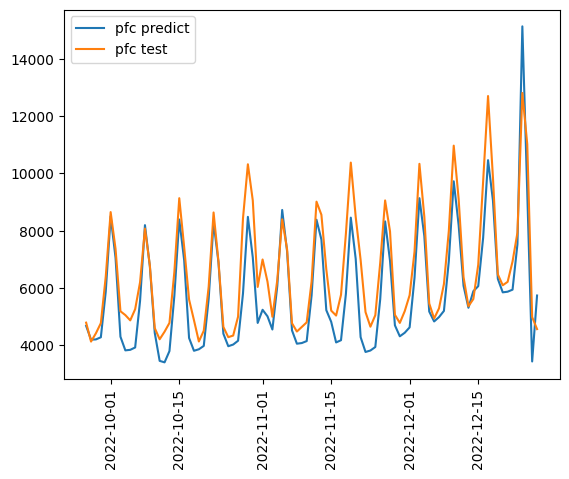

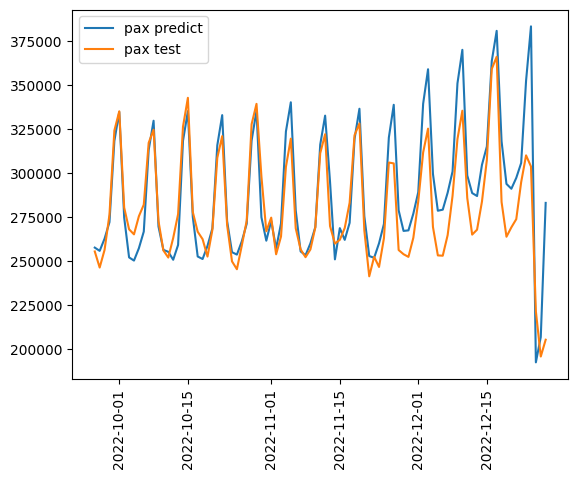

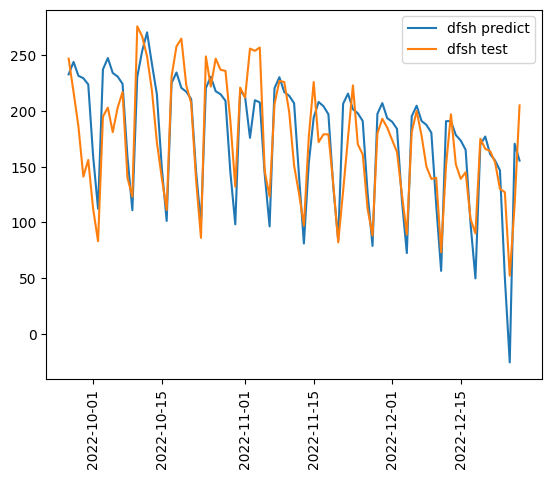

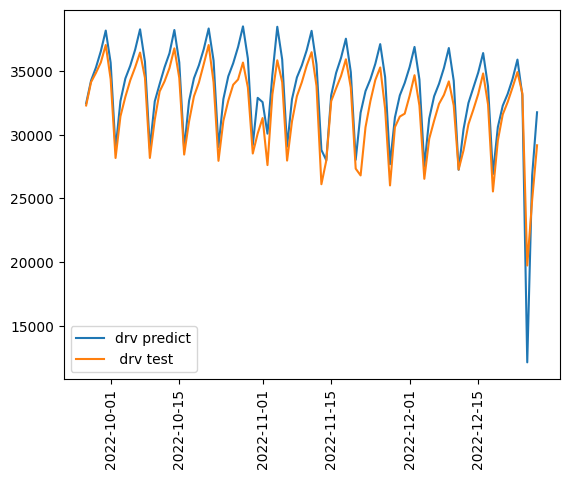

In [578]:
# PAX Test vs Predict
plt.plot( pfc_test_set.ds, pfc_predictions_prophet_tuned)
plt.plot( pfc_test_set.ds, pfc_test_set.y)
plt.xticks(rotation=90)
plt.legend([ 'pfc predict', 'pfc test'])
plt.show()

plt.plot( pax_test_set.ds, pax_predictions_prophet_tuned)
plt.plot( pax_test_set.ds, pax_test_set.y)
plt.xticks(rotation=90)
plt.legend([ 'pax predict', 'pax test'])
plt.show()

# DRV Test vs Predict
plt.plot( dfsh_test_set.ds, dfsh_predictions_prophet_tuned)
plt.plot( dfsh_test_set.ds, dfsh_test_set.y)
plt.xticks(rotation=90)
plt.legend([ 'dfsh predict', 'dfsh test'])
plt.show()

plt.plot( drv_test_set.ds, drv_predictions_prophet_tuned)
plt.plot( drv_test_set.ds, drv_test_set.y)
plt.xticks(rotation=90)
plt.legend([ 'drv predict', ' drv test'])
plt.show()



In [579]:
# regressor_coefficients PAX
print('PFC Regressors ' ,'\n',regressor_coefficients(pfc_m), '\n')
print('Ret Pax Regressors ' ,'\n',regressor_coefficients(pax_m), '\n')
print('DFSH Regressors ' ,'\n',regressor_coefficients(dfsh_m), '\n')
print('DRV Regressors ' ,'\n',regressor_coefficients(drv_m))

PFC Regressors  
           regressor  regressor_mode    center  coef_lower       coef  \
0  pax_acq_burn_pct  multiplicative  0.007958   40.020284  40.020284   
1      paycheck_day  multiplicative  0.000000    0.225865   0.225865   
2            Monday  multiplicative  0.000000   -0.036074  -0.036074   
3           Tuesday  multiplicative  0.000000   -0.141984  -0.141984   
4         Wednesday  multiplicative  0.000000   -0.133716  -0.133716   
5          Thursday  multiplicative  0.000000   -0.110908  -0.110908   
6          Saturday  multiplicative  0.000000    0.875283   0.875283   
7            Sunday  multiplicative  0.000000    0.543335   0.543335   

   coef_upper  
0   40.020284  
1    0.225865  
2   -0.036074  
3   -0.141984  
4   -0.133716  
5   -0.110908  
6    0.875283  
7    0.543335   

Ret Pax Regressors  
       regressor  regressor_mode  center  coef_lower      coef  coef_upper
0  paycheck_day  multiplicative     0.0    0.092320  0.092320    0.092320
1        Monday  

In [580]:
# MAE, RMSE and MAPE for PAX
print('Test vs Prediction PFC MAE ',round(mean_absolute_error(pfc_test_set['y'],pfc_predictions_prophet_tuned),0))
print('Test vs Prediction PFC RMSE ',round(np.sqrt(mean_squared_error(pfc_test_set['y'], pfc_predictions_prophet_tuned)),0))
print('Test vs Prediction PFC MAPE ',MAPE(pfc_test_set['y'], pfc_predictions_prophet_tuned), '\n')

print('Test vs Prediction PAX MAE ',round(mean_absolute_error(pax_test_set['y'],pax_predictions_prophet_tuned),0))
print('Test vs Prediction PAX RMSE ',round(np.sqrt(mean_squared_error(pax_test_set['y'], pax_predictions_prophet_tuned)),0))
print('Test vs Prediction PAX MAPE ',MAPE(pax_test_set['y'], pax_predictions_prophet_tuned), '\n')

# MAE, RMSE and MAPE for DRV
print('Test vs Prediction DFSH MAE ',round(mean_absolute_error(dfsh_test_set['y'],dfsh_predictions_prophet_tuned),0))
print('Test vs Prediction DFSH RMSE ',round(np.sqrt(mean_squared_error(dfsh_test_set['y'], dfsh_predictions_prophet_tuned)),0))
print('Test vs Prediction DFSH MAPE ',MAPE(dfsh_test_set['y'], dfsh_predictions_prophet_tuned), '\n')

print('Test vs Prediction DRV MAE ',round(mean_absolute_error(drv_test_set['y'],drv_predictions_prophet_tuned),0))
print('Test vs Prediction DRV RMSE ',round(np.sqrt(mean_squared_error(drv_test_set['y'], drv_predictions_prophet_tuned)),0))
print('Test vs Prediction DRV MAPE ',MAPE(drv_test_set['y'], drv_predictions_prophet_tuned), '\n')

Test vs Prediction PFC MAE  839.0
Test vs Prediction PFC RMSE  1044.0
Test vs Prediction PFC MAPE  12.6497581832781 

Test vs Prediction PAX MAE  13982.0
Test vs Prediction PAX RMSE  19575.0
Test vs Prediction PAX MAPE  5.084318699937042 

Test vs Prediction DFSH MAE  26.0
Test vs Prediction DFSH RMSE  33.0
Test vs Prediction DFSH MAPE  17.198605749115046 

Test vs Prediction DRV MAE  1551.0
Test vs Prediction DRV RMSE  1833.0
Test vs Prediction DRV MAPE  5.020795120555663 



# Cross Validation Tuned

In [581]:
# Cross Validation over tuned model PAX
pfc_cv = cross_validation(pfc_m, horizon = '91 days', initial = '540 days', parallel= 'processes')
pax_cv = cross_validation(pax_m, horizon = '91 days', initial = '540 days', parallel= 'processes')

# Cross Validation over tuned model PAX
dfsh_cv = cross_validation(dfsh_m, horizon = '91 days', initial = '540 days', parallel= 'processes')
drv_cv = cross_validation(drv_m, horizon = '91 days', initial = '540 days', parallel= 'processes')
drv_cv.head()


15:24:00 - cmdstanpy - INFO - Chain [1] start processing
15:24:00 - cmdstanpy - INFO - Chain [1] start processing
15:24:00 - cmdstanpy - INFO - Chain [1] start processing
15:24:00 - cmdstanpy - INFO - Chain [1] done processing
15:24:00 - cmdstanpy - INFO - Chain [1] done processing
15:24:00 - cmdstanpy - INFO - Chain [1] done processing
15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:02 - cmdstanpy - INFO - Chain [1] done processing
15:24:02 - cmdstanpy - INFO - Chain [1] done processing
15:24:03 - cmdstanpy - INFO - Chain [1] done processing
15:24:04 - cmdstanpy - INFO - Chain [1] start processing
15:24:04 - cmdstanpy - INFO - Chain [1] start processing
15:24:04 - cmdstanpy - INFO - Chain [1] start processing
15:24:04 - cmdstanpy - INFO - Chain [1] done processing
15:24:04 - cmdstanpy - INFO - Chain [1] done processing
15:24:05 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-03-28,30287.112619,29380.721094,31119.025677,31024.0,2022-03-27
1,2022-03-29,32061.939893,31172.354919,32966.355041,33169.0,2022-03-27
2,2022-03-30,33243.009928,32274.803556,34207.878400,30444.0,2022-03-27
3,2022-03-31,34575.823864,33642.768705,35441.138398,34817.0,2022-03-27
4,2022-04-01,36295.088165,35421.715716,37162.764227,36022.0,2022-03-27


In [582]:
# Errors from Cross Validation PAX
print('CV PFC MAE ',round(mean_absolute_error(pfc_cv['y'],pfc_cv['yhat']),0))
print('CV PFC RMSE ',round(np.sqrt(mean_squared_error(pfc_cv['y'], pfc_cv['yhat'])),0))
print('CV PFC MAPE ',MAPE(pfc_cv['y'], pfc_cv['yhat']), '\n')

print('CV PAX MAE ',round(mean_absolute_error(pax_cv['y'],pax_cv['yhat']),0))
print('CV PAX RMSE ',round(np.sqrt(mean_squared_error(pax_cv['y'], pax_cv['yhat'])),0))
print('CV PAX MAPE ',MAPE(pax_cv['y'], pax_cv['yhat']), '\n')

# Errors from Cross Validation PAX
print('CV DFSH MAE ',round(mean_absolute_error(dfsh_cv['y'],dfsh_cv['yhat']),0))
print('CV DFSH RMSE ',round(np.sqrt(mean_squared_error(dfsh_cv['y'], dfsh_cv['yhat'])),0))
print('CV DFSH MAPE ',MAPE(dfsh_cv['y'], dfsh_cv['yhat']), '\n')

print('CV DRV MAE ',round(mean_absolute_error(drv_cv['y'],drv_cv['yhat']),0))
print('CV DRV RMSE ',round(np.sqrt(mean_squared_error(drv_cv['y'], drv_cv['yhat'])),0))
print('CV DRV MAPE ',MAPE(drv_cv['y'], drv_cv['yhat']))

CV PFC MAE  1136.0
CV PFC RMSE  1374.0
CV PFC MAPE  18.951298993216806 

CV PAX MAE  14351.0
CV PAX RMSE  17472.0
CV PAX MAPE  5.218438003101872 

CV DFSH MAE  49.0
CV DFSH RMSE  63.0
CV DFSH MAPE  23.92929414925153 

CV DRV MAE  1339.0
CV DRV RMSE  1647.0
CV DRV MAPE  4.058130092685594


# Forecast Visualization

In [583]:
# # Visualize forecast for Pax
# pfc_fig = pfc_m.plot(pfc_forecast, xlabel='Date', ylabel='pfc pax cnt');
# pfc_ax = pfc_fig.gca()
# pfc_ax.set_title("PFC PAX Tuned Prediction", size=24)
# pfc_ax = add_changepoints_to_plot(pfc_fig.gca(), pfc_m, pfc_forecast)
# # pfc_ax.set_title("PFC PAX Tuned Prediction", size=24)

# pax_fig = pax_m.plot(pax_forecast, xlabel='Date', ylabel='retained pax cnt');
# pax_ax = pax_fig.gca()
# pax_ax.set_title("Retained PAX Tuned Prediction", size=24)
# pax_ax = add_changepoints_to_plot(pax_fig.gca(), pax_m, pax_forecast)


# # Visualize forecast for Drv
# dfsh_fig = dfsh_m.plot(dfsh_forecast, xlabel='Date', ylabel='dfsh drv cnt');
# dfsh_ax = dfsh_fig.gca()
# dfsh_ax.set_title("DSFSH DRV Tuned Prediction", size=24)
# dfsh_ax = add_changepoints_to_plot(dfsh_fig.gca(), dfsh_m, dfsh_forecast)


# drv_fig = drv_m.plot(drv_forecast, xlabel='Date', ylabel='retained drv cnt');
# drv_ax = drv_fig.gca()
# drv_ax.set_title("Retained DRV Tuned Prediction", size=24)
# drv_ax = add_changepoints_to_plot(drv_fig.gca(), drv_m, drv_forecast)


In [584]:
# # Plot components PAX
# pfc_fig2 = pfc_m.plot_components(pfc_forecast); 
# pfc_ax2 = pfc_fig2.gca()
# pfc_ax2.set_title("PFC PAX Components", size=24)

# pax_fig2 = pax_m.plot_components(pax_forecast); 
# pax_ax2 = pax_fig2.gca()
# pax_ax2.set_title("Retained PAX Components", size=24)

# # Plot components DRV
# dfsh_fig2 = dfsh_m.plot_components(dfsh_forecast); 
# dfsh_ax2 = dfsh_fig2.gca()
# dfsh_ax2.set_title("DFSH DRV Components", size=24)

# drv_fig2 = drv_m.plot_components(drv_forecast); 
# drv_ax2 = drv_fig2.gca()
# drv_ax2.set_title("Retained DRV Components", size=24)

In [585]:
# pfc_plotly
# plot_plotly(pfc_m, pfc_forecast)
# plot_plotly(pax_m, pax_forecast)
# plot_plotly(dfsh_m, dfsh_forecast)
# plot_plotly(drv_m, drv_forecast)

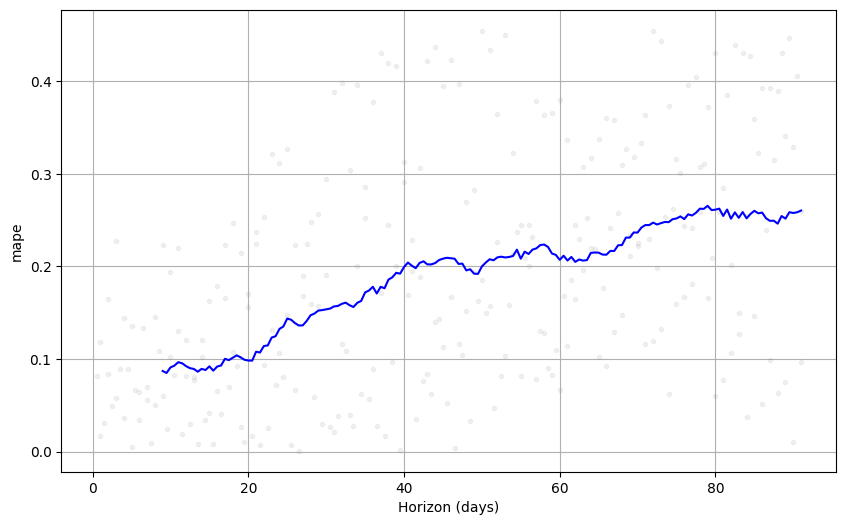

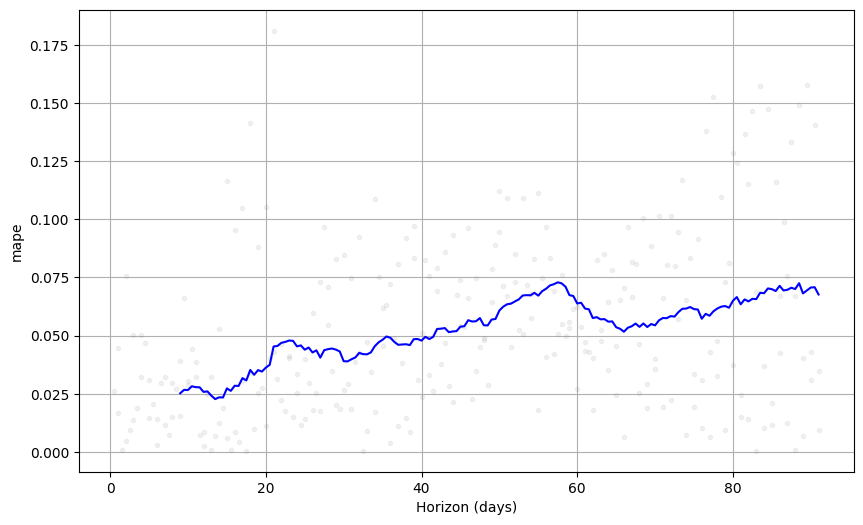

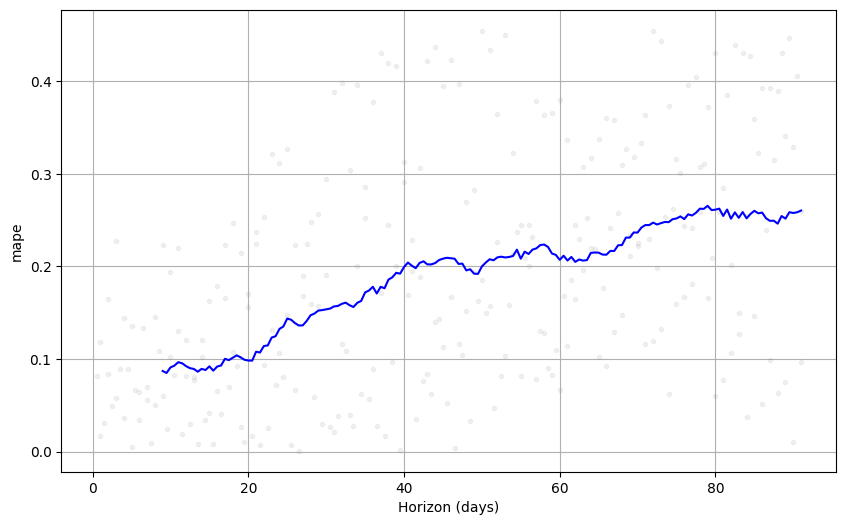

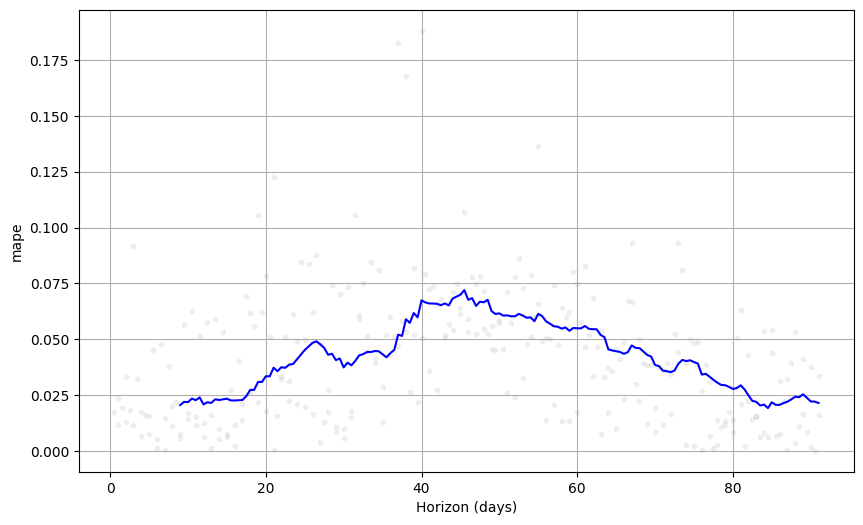

In [586]:
pfc_fig3 = plot_cross_validation_metric(pfc_cv, metric='mape')
pax_fig3 = plot_cross_validation_metric(pax_cv, metric='mape')
dfsh_fig3 = plot_cross_validation_metric(pfc_cv, metric='mape')
drv_fig3 = plot_cross_validation_metric(drv_cv, metric='mape')

<AxesSubplot: xlabel='y', ylabel='yhat'>

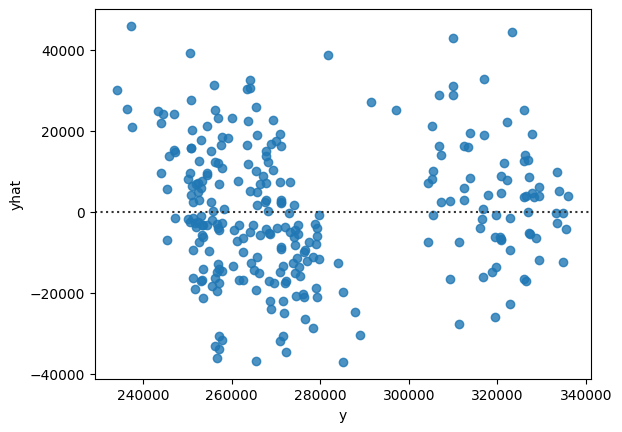

In [587]:

#sns.jointplot(data = df_cv , y = 'yhat',x = 'y' ,kind="reg" )
sns.residplot(data = pax_cv , y = 'yhat',x = 'y' ,robust=True, line_kws=dict(color="r"),dropna = True, order = 1)
#sns.regplot(data = df_cv , y = 'yhat',x = 'y'  )

# Frequency of Calls and TSH calculations

In [588]:
# Filters
city_id_filter = 52090100 # --> CDMX 
country_code_filter = 'MX'

# Mater File of Predicted PAX Variables
pfc_freq_df = (pd.DataFrame(
    data = master, columns=['current_stat_date','city_id', 'pfc_cpp','pfc_pax_cnt','pfc_calls'])
    .rename(columns = {'current_stat_date': 'ds'}))
pfc_freq_df = pfc_freq_df[(pfc_freq_df.city_id == city_id_filter)]

pax_freq_df = (pd.DataFrame(
    data = master, columns=['current_stat_date','city_id','retained_cpp','retained_pax_cnt','retained_calls' ])
    .rename(columns = {'current_stat_date': 'ds'}))
pax_freq_df = pax_freq_df[(pax_freq_df.city_id == city_id_filter)]

# Mater File of Predicted DRV Variables
dfsh_freq_df = (pd.DataFrame(
    data = master, columns=['current_stat_date','city_id','dfsh_shpd','dfsh_cnt', 'dfsh_online_time'])
    .rename(columns = {'current_stat_date': 'ds'}))
dfsh_freq_df = dfsh_freq_df[(dfsh_freq_df.city_id == city_id_filter)]

drv_freq_df = (pd.DataFrame(
    data = master, columns=['current_stat_date','city_id', 'retained_drv_shpd','retained_drv_cnt', 'retained_drv_online_time'])
    .rename(columns = {'current_stat_date': 'ds'}))
drv_freq_df = drv_freq_df[(drv_freq_df.city_id == city_id_filter)]

In [589]:
# Creating frequency datasets with dates
columns_drop = ['date_id','month','month_name','day','day_of_year','weekday_name','formatted_date','quartal','year_quartal','year_month', 'weekend', 'period','ds']

pfc_freq_df = dates.merge(pfc_freq_df, how = 'left', left_on = 'date_value', right_on = 'ds').drop(columns=columns_drop)
pfc_freq_df = pfc_freq_df[(pfc_freq_df.date_value >= '2020-09-01')&(pfc_freq_df.date_value <= '2023-12-31')]

pax_freq_df = dates.merge(pax_freq_df, how = 'left', left_on = 'date_value', right_on = 'ds').drop(columns=columns_drop)
pax_freq_df = pax_freq_df[(pax_freq_df.date_value >= '2020-09-01')&(pax_freq_df.date_value <= '2023-12-31')]

dfsh_freq_df = dates.merge(dfsh_freq_df, how = 'left', left_on = 'date_value', right_on = 'ds').drop(columns=columns_drop)
dfsh_freq_df = dfsh_freq_df[(dfsh_freq_df.date_value >= '2020-09-01')&(dfsh_freq_df.date_value <= '2023-12-31')]

drv_freq_df = dates.merge(drv_freq_df, how = 'left', left_on = 'date_value', right_on = 'ds').drop(columns=columns_drop)
drv_freq_df = drv_freq_df[(drv_freq_df.date_value >= '2020-09-01')&(drv_freq_df.date_value <= '2023-12-31')]

In [590]:
# Left join with prev year and weeks

# PFC frequency DF Joins
pfc_freq_df['last_year'] = pfc_freq_df['rank'] +52

pfc_freq_df['last_week'] = pfc_freq_df['rank'] +1
pfc_freq_df['last2_week'] = pfc_freq_df['rank'] +2
pfc_freq_df['last3_week'] = pfc_freq_df['rank'] +3
pfc_freq_df['last4_week'] = pfc_freq_df['rank'] +4

pfc_freq_final = (
    pfc_freq_df.merge(pfc_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last_year','weekday'],suffixes=( None, '_ly'))
    .merge(pfc_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = [ 'last_week', 'weekday'],suffixes=( None, '_lw'))
    .merge(pfc_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = [ 'last2_week', 'weekday'],suffixes=( None, '_l2w'))
    .merge(pfc_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = [ 'last3_week', 'weekday'],suffixes=( None, '_l3w'))
    .merge(pfc_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last4_week', 'weekday'],suffixes=( None, '_l4w'))
    )
pfc_freq_final = pd.DataFrame(pfc_freq_final, columns=['rank','year','year_calendar_week','calendar_week','date_value','weekday','city_id', 'pfc_cpp', 'pfc_cpp_ly', 'pfc_cpp_lw', 'pfc_cpp_l2w', 'pfc_cpp_l3w', 'pfc_cpp_l4w'])

# Pax frequency DF Joins
pax_freq_df['last_year'] = pax_freq_df['rank']+52

pax_freq_df['last_week'] = pax_freq_df['rank'] +1
pax_freq_df['last2_week'] = pax_freq_df['rank'] +2
pax_freq_df['last3_week'] = pax_freq_df['rank'] +3
pax_freq_df['last4_week'] = pax_freq_df['rank'] +4

pax_freq_final = (
    pax_freq_df.merge(pax_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last_year', 'weekday'],suffixes=( None, '_ly'))
    .merge(pax_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last_week', 'weekday'],suffixes=( None, '_lw'))
    .merge(pax_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last2_week', 'weekday'],suffixes=( None, '_l2w'))
    .merge(pax_freq_df, how = 'left', left_on = ['rank', 'weekday'], right_on = ['last3_week', 'weekday'],suffixes=( None, '_l3w'))
    .merge(pax_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last4_week', 'weekday'],suffixes=( None, '_l4w'))
    )
pax_freq_final = pd.DataFrame(pax_freq_final, columns=['rank','year','year_calendar_week','calendar_week','date_value','weekday','city_id', 'retained_cpp', 'retained_cpp_ly', 'retained_cpp_lw','retained_cpp_l2w', 'retained_cpp_l3w','retained_cpp_l4w'])

# DFSH frequency DF Joins
dfsh_freq_df['last_year'] = dfsh_freq_df['rank'] +52

dfsh_freq_df['last_week'] = dfsh_freq_df['rank'] +1
dfsh_freq_df['last2_week'] = dfsh_freq_df['rank'] +2
dfsh_freq_df['last3_week'] = dfsh_freq_df['rank'] +3
dfsh_freq_df['last4_week'] = dfsh_freq_df['rank'] +4

dfsh_freq_final = (
    dfsh_freq_df.merge(dfsh_freq_df, how = 'left', left_on = ['rank', 'weekday'], right_on = ['last_year', 'weekday'],suffixes=( None, '_ly'))
    .merge(dfsh_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last_week', 'weekday'],suffixes=( None, '_lw'))
    .merge(dfsh_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last2_week', 'weekday'],suffixes=( None, '_l2w'))
    .merge(dfsh_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last3_week', 'weekday'],suffixes=( None, '_l3w'))
    .merge(dfsh_freq_df, how = 'left', left_on = [ 'rank', 'weekday'], right_on = ['last4_week', 'weekday'],suffixes=( None, '_l4w'))
    )
dfsh_freq_final = pd.DataFrame(dfsh_freq_final, columns=['rank','year','year_calendar_week','calendar_week','date_value','weekday','city_id', 'dfsh_shpd', 'dfsh_shpd_ly', 'dfsh_shpd_lw','dfsh_shpd_l2w', 'dfsh_shpd_l3w','dfsh_shpd_l4w'])

# DRV frequency DF Joins
drv_freq_df['last_year'] = drv_freq_df['rank'] +52

drv_freq_df['last_week'] = drv_freq_df['rank'] +1
drv_freq_df['last2_week'] = drv_freq_df['rank'] +2
drv_freq_df['last3_week'] = drv_freq_df['rank'] +3
drv_freq_df['last4_week'] = drv_freq_df['rank'] +4

drv_freq_final = (
    drv_freq_df.merge(drv_freq_df, how = 'left', left_on = ['rank', 'weekday'], right_on = ['last_year', 'weekday'],suffixes=( None, '_ly'))
    .merge(drv_freq_df, how = 'left', left_on = ['rank',  'weekday'], right_on = ['last_week', 'weekday'],suffixes=( None, '_lw'))
    .merge(drv_freq_df, how = 'left', left_on = ['rank',  'weekday'], right_on = ['last2_week', 'weekday'],suffixes=( None, '_l2w'))
    .merge(drv_freq_df, how = 'left', left_on = ['rank',  'weekday'], right_on = ['last3_week', 'weekday'],suffixes=( None, '_l3w'))
    .merge(drv_freq_df, how = 'left', left_on = ['rank',  'weekday'], right_on = ['last4_week', 'weekday'],suffixes=( None, '_l4w'))
    )
drv_freq_final = pd.DataFrame(drv_freq_final
                , columns=['rank','year','year_calendar_week','calendar_week','date_value','weekday','city_id', 'retained_drv_shpd', 'retained_drv_shpd_ly', 'retained_drv_shpd_lw','retained_drv_shpd_l2w'
                , 'retained_drv_shpd_l3w','retained_drv_shpd_l4w','last_week', 'last_2week', 'last_3week', 'last_4week' ])


In [591]:
pfc_freq_final['pfc_cpp_lweeks'] = (pfc_freq_final.pfc_cpp_lw
                                + pfc_freq_final.pfc_cpp_l2w
                                + pfc_freq_final.pfc_cpp_l3w
                                + pfc_freq_final.pfc_cpp_l4w ) / 4


pax_freq_final['retained_cpp_lweeks'] = (pax_freq_final.retained_cpp_lw
                                + pax_freq_final.retained_cpp_l2w
                                + pax_freq_final.retained_cpp_l3w
                                + pax_freq_final.retained_cpp_l4w ) / 4

dfsh_freq_final['dfsh_shpd_lweeks'] = (dfsh_freq_final.dfsh_shpd_lw
                                + dfsh_freq_final.dfsh_shpd_l2w
                                + dfsh_freq_final.dfsh_shpd_l3w
                                + dfsh_freq_final.dfsh_shpd_l4w ) / 4

drv_freq_final['retained_drv_shpd_lweeks'] = (drv_freq_final.retained_drv_shpd_lw
                                + drv_freq_final.retained_drv_shpd_l2w
                                + drv_freq_final.retained_drv_shpd_l3w
                                + drv_freq_final.retained_drv_shpd_l4w ) / 4

In [625]:
pfc_freq_final = pd.DataFrame(pfc_freq_final, columns = ['rank', 'year', 'year_calendar_week', 'calendar_week', 'date_value', 'weekday', 'city_id', 'pfc_cpp_ly', 'pfc_cpp_lweeks', 'pfc_cpp'])
pfc_freq_final['pfc_cpp_lweeks'].ffill(axis=0,inplace=True)
pfc_freq_final['city_id'].ffill(axis=0,inplace=True)
pfc_freq_final['pfc_cpp_pred'] = (pfc_freq_final.pfc_cpp_lweeks*0.2+pfc_freq_final.pfc_cpp_ly*0.8)
pfc_freq_final['pfc_cpp_pred'] =np.where(pfc_freq_final.pfc_cpp_pred.isnull(),pfc_freq_final.pfc_cpp,pfc_freq_final.pfc_cpp_pred)

pax_freq_final = pd.DataFrame(pax_freq_final, columns = ['rank', 'year', 'year_calendar_week', 'calendar_week', 'date_value', 'weekday', 'city_id', 'retained_cpp_ly', 'retained_cpp_lweeks','retained_cpp' ])
pax_freq_final['retained_cpp_lweeks'].ffill(axis=0,inplace=True)
pax_freq_final['city_id'].ffill(axis=0,inplace=True)
pax_freq_final['retained_cpp_pred'] = (pax_freq_final.retained_cpp_lweeks*0.2+pax_freq_final.retained_cpp_ly*0.8)
pax_freq_final['retained_cpp_pred'] = np.where(pax_freq_final.retained_cpp_pred.isnull(),pax_freq_final.retained_cpp,pax_freq_final.retained_cpp_pred)

dfsh_freq_final = pd.DataFrame(dfsh_freq_final, columns = ['rank', 'year', 'year_calendar_week', 'calendar_week', 'date_value', 'weekday', 'city_id', 'dfsh_shpd_ly', 'dfsh_shpd_lweeks','dfsh_shpd'])
dfsh_freq_final['dfsh_shpd_lweeks'].ffill(axis=0,inplace=True)
dfsh_freq_final['city_id'].ffill(axis=0,inplace=True)
dfsh_freq_final['dfsh_shpd_pred'] = (dfsh_freq_final.dfsh_shpd_lweeks*0.2+dfsh_freq_final.dfsh_shpd_ly*0.8)
dfsh_freq_final['dfsh_shpd_pred'] = np.where(dfsh_freq_final.dfsh_shpd_pred.isnull(),dfsh_freq_final.dfsh_shpd, dfsh_freq_final.dfsh_shpd_pred)

drv_freq_final = pd.DataFrame(drv_freq_final, columns = ['rank', 'year', 'year_calendar_week', 'calendar_week', 'date_value', 'weekday', 'city_id', 'retained_drv_shpd_ly', 'retained_drv_shpd_lweeks','retained_drv_shpd'])
drv_freq_final['retained_drv_shpd_lweeks'].ffill(axis=0,inplace=True)
drv_freq_final['city_id'].ffill(axis=0,inplace=True)
drv_freq_final['retained_drv_shpd_pred'] = (drv_freq_final.retained_drv_shpd_lweeks*0.2+drv_freq_final.retained_drv_shpd_ly*0.8)
drv_freq_final['retained_drv_shpd_pred'] = np.where(drv_freq_final.retained_drv_shpd_pred.isnull(),drv_freq_final.retained_drv_shpd,drv_freq_final.retained_drv_shpd_pred)

In [593]:
frequency_df = (pfc_freq_final.merge(pax_freq_final, how = 'left', on = 'date_value', suffixes = (None, '_x'))
                .merge(dfsh_freq_final, how = 'left', on = 'date_value', suffixes = (None, '_y'))
                .merge(drv_freq_final, how = 'left', on = 'date_value', suffixes = (None, '_z'))
                )
frequency_df = pd.DataFrame(frequency_df, columns = ['rank', 'year', 'year_calendar_week', 'calendar_week', 'date_value', 'weekday', 'city_id','pfc_cpp_pred','retained_cpp_pred','dfsh_shpd_pred','retained_drv_shpd_pred'])

In [594]:
# Check
frequency_df[(frequency_df.year == 2020)&(frequency_df.calendar_week<=5)]

,rank,year,year_calendar_week,calendar_week,date_value,weekday,city_id,pfc_cpp_pred,retained_cpp_pred,dfsh_shpd_pred,retained_drv_shpd_pred
118,18,2020,2021/01,1,2020-12-28,1,52090100.0,1.263310,1.471131,3.805657,8.774893
119,18,2020,2021/01,1,2020-12-29,2,52090100.0,1.268752,1.478248,3.186723,9.113271
120,18,2020,2021/01,1,2020-12-30,3,52090100.0,1.248776,1.494640,3.255712,9.402272
121,18,2020,2021/01,1,2020-12-31,4,52090100.0,1.217151,1.476744,3.474501,10.933301


# Predict next 90 Days

In [595]:
date_pred =  pd.DataFrame(dates, columns = ['date_value', 'rank', 'weekday'])
date_pred['day_of_week'] = date_pred.date_value.dt.day_name()
col = ['day_of_week']
for i in col: 
      date_pred[i] = date_pred[i].astype('category')
date_pred =  pd.concat((date_pred,pd.get_dummies(date_pred['day_of_week'], drop_first= True)), axis = 1)

In [596]:
# Create Future Dataframe PAX
pfc_pred = pfc_m.make_future_dataframe(periods = testdays +93, freq = 'D')
pax_pred = pax_m.make_future_dataframe(periods = testdays+93, freq = 'D')

# Create Future Dataframe DRV
dfsh_pred= dfsh_m.make_future_dataframe(periods = testdays+93, freq = 'D')
drv_pred = drv_m.make_future_dataframe(periods = testdays+93, freq = 'D')

In [597]:
# Merge Regressors pax
pfc_pred = pfc_pred.merge(master_pfc_df, how = 'left', on = 'ds').merge(paychecks, how = 'left', left_on = 'ds', right_on = 'formatted_date', suffixes = (None,'_x')).merge(date_pred, how = 'left', left_on = 'ds', right_on = 'date_value', suffixes = (None,'_x'))
pfc_pred['paycheck_day'] = pfc_pred['paycheck_day_x']
pfc_pred['Monday'] = pfc_pred['Monday_x']
pfc_pred['Tuesday'] = pfc_pred['Tuesday_x']
pfc_pred['Wednesday'] = pfc_pred['Wednesday_x']
pfc_pred['Thursday'] = pfc_pred['Thursday_x']
pfc_pred['Saturday'] = pfc_pred['Saturday_x']
pfc_pred['Sunday'] = pfc_pred['Sunday_x']
pfc_pred['pax_acq_burn'] = pfc_pred['Sunday_x']
pfc_pred = pfc_pred.drop(columns =  ['paycheck_day_x', 'weekend_flag', 'formatted_date','date_value','day_of_week','Monday_x','Tuesday_x','Wednesday_x', 'Thursday_x',  'Saturday_x', 'Sunday_x' ])
pfc_pred['rank_ly'] = pfc_pred['rank'] +52
pfc_pred = pfc_pred.merge(pfc_pred, how= 'left', left_on = ['rank', 'weekday'], right_on = ['rank_ly', 'weekday'], suffixes = (None, '_y'))

pax_pred = pax_pred.merge(master_pax_df, how = 'left', on = 'ds').merge(paychecks, how = 'left', left_on = 'ds', right_on = 'formatted_date', suffixes = (None,'_x')).merge(date_pred, how = 'left', left_on = 'ds', right_on = 'date_value', suffixes = (None,'_x'))
pax_pred['paycheck_day'] = pax_pred['paycheck_day_x']
pax_pred['Monday'] = pax_pred['Monday_x']
pax_pred['Tuesday'] = pax_pred['Tuesday_x']
pax_pred['Wednesday'] = pax_pred['Wednesday_x']
pax_pred['Thursday'] = pax_pred['Thursday_x']
pax_pred['Saturday'] = pax_pred['Saturday_x']
pax_pred['Sunday'] = pax_pred['Sunday_x']
pax_pred = pax_pred.drop(columns =  ['paycheck_day_x', 'weekend_flag', 'formatted_date','date_value','day_of_week','Monday_x','Tuesday_x','Wednesday_x', 'Thursday_x',  'Saturday_x', 'Sunday_x' ])

# # Merge Regressors drv
dfsh_pred = dfsh_pred.merge(master_dfsh_df, how = 'left', on = 'ds').merge(paychecks, how = 'left', left_on = 'ds', right_on = 'formatted_date', suffixes = (None,'_x')).merge(date_pred, how = 'left', left_on = 'ds', right_on = 'date_value', suffixes = (None,'_x'))
dfsh_pred['paycheck_day'] = dfsh_pred['paycheck_day_x']
dfsh_pred['Monday'] = dfsh_pred['Monday_x']
dfsh_pred['Tuesday'] = dfsh_pred['Tuesday_x']
dfsh_pred['Wednesday'] = dfsh_pred['Wednesday_x']
dfsh_pred['Thursday'] = dfsh_pred['Thursday_x']
dfsh_pred['Saturday'] = dfsh_pred['Saturday_x']
dfsh_pred['Sunday'] = dfsh_pred['Sunday_x']
dfsh_pred = dfsh_pred.drop(columns =  ['paycheck_day_x', 'weekend_flag', 'formatted_date','date_value','day_of_week','Monday_x','Tuesday_x','Wednesday_x', 'Thursday_x',  'Saturday_x', 'Sunday_x' ])

drv_pred = drv_pred.merge(master_drv_df, how = 'left', on = 'ds').merge(paychecks, how = 'left', left_on = 'ds', right_on = 'formatted_date', suffixes = (None,'_x')).merge(date_pred, how = 'left', left_on = 'ds', right_on = 'date_value', suffixes = (None,'_x'))
drv_pred['paycheck_day'] = drv_pred['paycheck_day_x']
drv_pred['Monday'] = drv_pred['Monday_x']
drv_pred['Tuesday'] = drv_pred['Tuesday_x']
drv_pred['Wednesday'] = drv_pred['Wednesday_x']
drv_pred['Thursday'] = drv_pred['Thursday_x']
drv_pred['Saturday'] = drv_pred['Saturday_x']
drv_pred['Sunday'] = drv_pred['Sunday_x']
drv_pred = drv_pred.drop(columns =  ['paycheck_day_x', 'weekend_flag', 'formatted_date','date_value','day_of_week','Monday_x','Tuesday_x','Wednesday_x', 'Thursday_x',  'Saturday_x', 'Sunday_x' ])

In [598]:
# Check
pfc_pred = pfc_pred.drop(columns =  ['ds_y', 'y_y', 'paycheck_day_y',
       'Monday_y', 'Tuesday_y', 'Wednesday_y', 'Thursday_y', 'Saturday_y',
       'Sunday_y', 'rank_y', 'rank_ly_y', 'pax_acq_burn_y'])
pfc_pred.pax_acq_burn_pct = np.where(pfc_pred['pax_acq_burn_pct'].isnull(),pfc_pred['pax_acq_burn_pct_y'],pfc_pred['pax_acq_burn_pct'])


In [599]:
# Forecast PAX
pfc_prediction = pfc_m.predict(pfc_pred)
pfc_prediction = pfc_prediction.rename(columns = {'yhat':'pfc_prediction', 'yhat_lower': 'pfc_lower', 'yhat_upper': 'pfc_upper'}) 
pax_prediction  = pax_m.predict(pax_pred)
pax_prediction = pax_prediction.rename(columns = {'yhat':'pax_prediction', 'yhat_lower': 'pax_lower', 'yhat_upper': 'pax_upper'}) 

# Forecast DRV
dfsh_prediction = dfsh_m.predict(dfsh_pred)
dfsh_prediction = dfsh_prediction.rename(columns = {'yhat':'dfsh_prediction', 'yhat_lower': 'dfsh_lower', 'yhat_upper': 'dfsh_upper'}) 
drv_prediction  = drv_m.predict(drv_pred)
drv_prediction = drv_prediction.rename(columns = {'yhat':'drv_prediction', 'yhat_lower': 'drv_lower', 'yhat_upper': 'drv_upper'}) 

In [600]:
# # Predictions PAX
pfc_predictions = pfc_prediction.pfc_prediction[-testdays:].rename('pfc prophet tuned')

# pfc_predictions.index = pfc_test_set['ds']
pax_predictions = pax_prediction.pax_prediction[-testdays:].rename('pax prophet final')
# pax_predictions.index = pax_prediction['ds']

# # Predictions DRV
dfsh_predictions = dfsh_prediction.dfsh_prediction[-testdays:].rename('dfsh prophet tuned')
# dfsh_predictions.index = dfsh_test_set['ds']

drv_predictions= drv_prediction.drv_prediction[-testdays:].rename('drv prophet tuned')
# drv_predictions.index = drv_test_set['ds']

In [601]:
predictions_df = pfc_prediction.merge(pax_prediction, how='left', on = 'ds',suffixes = (None, '_x')).merge(dfsh_prediction, how='left', on = 'ds', suffixes = (None, '_y')).merge(drv_prediction, how='left', on = 'ds', suffixes = (None, '_z'))
predictions_df = pd.DataFrame(predictions_df, columns = ['ds', 'pfc_prediction', 'pfc_lower', 'pfc_upper', 'pax_prediction', 'pax_lower', 'pax_upper', 'dfsh_prediction'
                                         , 'dfsh_lower', 'dfsh_upper', 'drv_prediction', 'drv_lower', 'drv_upper'])

In [602]:
predictions_df

,ds,pfc_prediction,pfc_lower,pfc_upper,pax_prediction,pax_lower,pax_upper,dfsh_prediction,dfsh_lower,dfsh_upper,drv_prediction,drv_lower,drv_upper
0,2020-09-01,6227.606989,5439.488277,7050.240697,148836.323754,137935.669873,159336.001366,355.071500,320.007585,384.618325,31566.016375,30696.851299,32493.271063
1,2020-09-02,6283.157398,5470.394112,7088.586257,153590.765368,143222.248258,164426.711916,333.754219,299.740362,367.343345,32556.866777,31644.459647,33488.973471
2,2020-09-03,6394.353257,5607.952174,7171.093984,159723.299253,148938.976872,170565.845243,327.994514,293.687180,360.629105,33791.251162,32913.477897,34751.919141
3,2020-09-04,8246.068832,7448.183262,9040.478596,186698.656957,176109.010174,197228.211699,317.430382,287.182027,351.003620,35343.066295,34371.030660,36283.695239
4,2020-09-05,11448.359804,10644.171206,12256.736544,197034.597775,186336.471467,206926.846501,219.840319,186.614565,251.669769,33017.022466,32050.212260,33930.673661
...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2023-03-26,8074.548326,-5741.357209,20231.688471,312684.069473,198083.863781,422881.065836,80.144090,47.626842,114.321024,26118.589118,17278.915273,34843.940647
937,2023-03-27,5469.281076,-4219.222531,13844.533189,293405.546826,183967.546843,397605.183939,199.016834,161.876252,236.312018,29905.664498,19499.791119,40041.747083
938,2023-03-28,4951.142117,-3738.352341,12553.803671,291841.490629,185229.771123,398752.322847,209.743196,169.660499,247.538139,31716.453544,20807.843692,42713.920023
939,2023-03-29,4942.062513,-3879.922876,12471.077122,299908.327925,183411.428048,405189.201124,198.066848,159.917831,235.675897,32767.396791,21291.420941,44153.625589


# Join Frequencies with Predictions

In [603]:
# Join Frequency with prediction
market_df = frequency_df.merge(predictions_df, how = 'left', left_on = 'date_value', right_on = 'ds', suffixes = (None,'_x'))
market_df = market_df.drop(columns = ['date_value'])
#market_df.dropna(subset=['ds']).columns
market_df.ds.max()
market_df = market_df[market_df.ds <= '2023-03-30']

In [604]:
market_df.columns
market_df

,rank,year,year_calendar_week,calendar_week,weekday,city_id,pfc_cpp_pred,retained_cpp_pred,dfsh_shpd_pred,retained_drv_shpd_pred,...,pfc_upper,pax_prediction,pax_lower,pax_upper,dfsh_prediction,dfsh_lower,dfsh_upper,drv_prediction,drv_lower,drv_upper
0,1,2020,2020/36,36,2,52090100.0,1.321309,1.572032,3.481288,7.173836,...,7050.240697,148836.323754,137935.669873,159336.001366,355.071500,320.007585,384.618325,31566.016375,30696.851299,32493.271063
1,1,2020,2020/36,36,3,52090100.0,1.336929,1.559539,3.137778,7.509972,...,7088.586257,153590.765368,143222.248258,164426.711916,333.754219,299.740362,367.343345,32556.866777,31644.459647,33488.973471
2,1,2020,2020/36,36,4,52090100.0,1.314777,1.552380,3.268199,7.728158,...,7171.093984,159723.299253,148938.976872,170565.845243,327.994514,293.687180,360.629105,33791.251162,32913.477897,34751.919141
3,1,2020,2020/36,36,5,52090100.0,1.318715,1.569034,3.004180,8.276742,...,9040.478596,186698.656957,176109.010174,197228.211699,317.430382,287.182027,351.003620,35343.066295,34371.030660,36283.695239
4,1,2020,2020/36,36,6,52090100.0,1.344369,1.605895,2.982263,8.151753,...,12256.736544,197034.597775,186336.471467,206926.846501,219.840319,186.614565,251.669769,33017.022466,32050.212260,33930.673661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,134,2023,2023/13,13,0,52090100.0,1.327677,1.486742,2.780474,8.545717,...,20231.688471,312684.069473,198083.863781,422881.065836,80.144090,47.626842,114.321024,26118.589118,17278.915273,34843.940647
937,135,2023,2023/14,14,1,52090100.0,1.322804,1.477176,3.864016,8.161479,...,13844.533189,293405.546826,183967.546843,397605.183939,199.016834,161.876252,236.312018,29905.664498,19499.791119,40041.747083
938,135,2023,2023/14,14,2,52090100.0,1.314637,1.453373,3.482974,8.191664,...,12553.803671,291841.490629,185229.771123,398752.322847,209.743196,169.660499,247.538139,31716.453544,20807.843692,42713.920023
939,135,2023,2023/14,14,3,52090100.0,1.328800,1.492947,3.472280,8.671280,...,12471.077122,299908.327925,183411.428048,405189.201124,198.066848,159.917831,235.675897,32767.396791,21291.420941,44153.625589


In [605]:
market_df = pd.DataFrame(market_df, columns = ['year_calendar_week', 'calendar_week', 'ds','city_id', 'pfc_cpp_pred', 'retained_cpp_pred', 'dfsh_shpd_pred',
       'retained_drv_shpd_pred', 'pfc_prediction', 'pfc_lower',
       'pfc_upper', 'pax_prediction', 'pax_lower', 'pax_upper',
       'dfsh_prediction', 'dfsh_lower', 'dfsh_upper', 
       'drv_prediction','drv_lower', 'drv_upper'])
market_df = market_df.assign(
    predicted_calls = (market_df.pfc_cpp_pred*market_df.pfc_prediction) + (market_df.retained_cpp_pred*market_df.pax_prediction),
    predicted_tsh = (market_df.dfsh_shpd_pred*market_df.dfsh_prediction) + (market_df.retained_drv_shpd_pred*market_df.drv_prediction),
    predicted_dsr = ((market_df.pfc_cpp_pred*market_df.pfc_prediction) + (market_df.retained_cpp_pred*market_df.pax_prediction)) / ((market_df.dfsh_shpd_pred*market_df.dfsh_prediction) + (market_df.retained_drv_shpd_pred*market_df.drv_prediction)),
    predicted_pfc_calls = market_df.pfc_cpp_pred*market_df.pfc_prediction,
    predicted_retained_calls = market_df.retained_cpp_pred*market_df.pax_prediction,
    predicted_dfsh_tsh = market_df.dfsh_shpd_pred*market_df.dfsh_prediction,
    predicted_drv_tsh = market_df.retained_drv_shpd_pred*market_df.drv_prediction
)
    
city_id_filter = 52090100 # --> CDMX 
rides_df = master[(master.city_id == city_id_filter)][['current_stat_date','rides','active_pax_calls', 'active_drv_online_time']]
rides_df['cr'] = rides_df.rides / rides_df.active_pax_calls
market_df = market_df.merge(rides_df, how='left',left_on = 'ds' ,right_on='current_stat_date', suffixes=(None,None))
market_df.drop(columns=['current_stat_date'],inplace= True)


In [606]:
filename = 'market_predictions2023Q1'
folder = '2023Q1'
predictions_folder = '2023 predictions'
market_df.to_csv('/Users/didi/Documents/Short Term Forecast/'+predictions_folder+'/'+folder+'/'+filename+'.csv', index = False)

In [607]:
market_df

,year_calendar_week,calendar_week,ds,city_id,pfc_cpp_pred,retained_cpp_pred,dfsh_shpd_pred,retained_drv_shpd_pred,pfc_prediction,pfc_lower,...,predicted_tsh,predicted_dsr,predicted_pfc_calls,predicted_retained_calls,predicted_dfsh_tsh,predicted_drv_tsh,rides,active_pax_calls,active_drv_online_time,cr
0,2020/36,36,2020-09-01,52090100.0,1.321309,1.572032,3.481288,7.173836,6227.606989,5439.488277,...,227685.542688,1.063766,8228.592283,233975.512064,1236.106012,226449.436676,195012.0,241129.0,224192.583333,0.808746
1,2020/36,36,2020-09-02,52090100.0,1.336929,1.559539,3.137778,7.509972,6283.157398,5470.394112,...,245548.401778,1.009703,8400.138231,239530.843877,1047.246570,244501.155208,199797.0,242067.0,247767.566667,0.825379
2,2020/36,36,2020-09-03,52090100.0,1.314777,1.552380,3.268199,7.728158,6394.353257,5607.952174,...,262216.094899,0.977661,8407.147627,247951.191480,1071.951420,261144.143479,206634.0,248931.0,264313.650000,0.830085
3,2020/36,36,2020-09-04,52090100.0,1.318715,1.569034,3.004180,8.276742,8246.068832,7448.183262,...,293479.070715,1.035204,10874.217430,292936.546735,953.618082,292525.452633,241612.0,296477.0,298851.900000,0.814943
4,2020/36,36,2020-09-05,52090100.0,1.344369,1.605895,2.982263,8.151753,11448.359804,10644.171206,...,269802.245867,1.229818,15390.821817,316416.970081,655.621650,269146.624218,264562.0,336609.0,268598.266667,0.785962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2023/13,13,2023-03-26,52090100.0,1.327677,1.486742,2.780474,8.545717,8074.548326,-5741.357209,...,223424.914984,2.128684,10720.393385,464880.660609,222.838581,223202.076402,NaN,NaN,NaN,NaN
937,2023/14,14,2023-03-27,52090100.0,1.322804,1.477176,3.864016,8.161479,5469.281076,-4219.222531,...,244843.465512,1.799707,7234.786181,433411.660878,769.004256,244074.461256,NaN,NaN,NaN,NaN
938,2023/14,14,2023-03-28,52090100.0,1.314637,1.453373,3.482974,8.191664,4951.142117,-3738.352341,...,260541.052088,1.652959,6508.953406,424154.647186,730.530072,259810.522016,NaN,NaN,NaN,NaN
939,2023/14,14,2023-03-29,52090100.0,1.328800,1.492947,3.472280,8.671280,4942.062513,-3879.922876,...,284823.026256,1.595076,6567.010644,447747.258648,687.743653,284135.282603,NaN,NaN,NaN,NaN


# DSR CR Regression

In [608]:
dsr_df = market_df.copy()

In [609]:
dsr_df = dsr_df.assign(
    predicted_calls = (dsr_df.pfc_cpp_pred*dsr_df.pfc_prediction) + (dsr_df.retained_cpp_pred*dsr_df.pax_prediction),
    predicted_tsh = (dsr_df.dfsh_shpd_pred*dsr_df.dfsh_prediction) + (dsr_df.retained_drv_shpd_pred*dsr_df.drv_prediction),
    predicted_dsr = ((dsr_df.pfc_cpp_pred*dsr_df.pfc_prediction) + (dsr_df.retained_cpp_pred*dsr_df.pax_prediction)) / ((dsr_df.dfsh_shpd_pred*dsr_df.dfsh_prediction) + (dsr_df.retained_drv_shpd_pred*dsr_df.drv_prediction)),
    predicted_pfc_calls = dsr_df.pfc_cpp_pred*dsr_df.pfc_prediction,
    predicted_retained_calls = dsr_df.retained_cpp_pred*dsr_df.pax_prediction,
    predicted_dfsh_tsh = dsr_df.dfsh_shpd_pred*dsr_df.dfsh_prediction,
    predicted_drv_tsh = dsr_df.retained_drv_shpd_pred*dsr_df.drv_prediction
)

In [610]:
dsr_df

,year_calendar_week,calendar_week,ds,city_id,pfc_cpp_pred,retained_cpp_pred,dfsh_shpd_pred,retained_drv_shpd_pred,pfc_prediction,pfc_lower,...,predicted_tsh,predicted_dsr,predicted_pfc_calls,predicted_retained_calls,predicted_dfsh_tsh,predicted_drv_tsh,rides,active_pax_calls,active_drv_online_time,cr
0,2020/36,36,2020-09-01,52090100.0,1.321309,1.572032,3.481288,7.173836,6227.606989,5439.488277,...,227685.542688,1.063766,8228.592283,233975.512064,1236.106012,226449.436676,195012.0,241129.0,224192.583333,0.808746
1,2020/36,36,2020-09-02,52090100.0,1.336929,1.559539,3.137778,7.509972,6283.157398,5470.394112,...,245548.401778,1.009703,8400.138231,239530.843877,1047.246570,244501.155208,199797.0,242067.0,247767.566667,0.825379
2,2020/36,36,2020-09-03,52090100.0,1.314777,1.552380,3.268199,7.728158,6394.353257,5607.952174,...,262216.094899,0.977661,8407.147627,247951.191480,1071.951420,261144.143479,206634.0,248931.0,264313.650000,0.830085
3,2020/36,36,2020-09-04,52090100.0,1.318715,1.569034,3.004180,8.276742,8246.068832,7448.183262,...,293479.070715,1.035204,10874.217430,292936.546735,953.618082,292525.452633,241612.0,296477.0,298851.900000,0.814943
4,2020/36,36,2020-09-05,52090100.0,1.344369,1.605895,2.982263,8.151753,11448.359804,10644.171206,...,269802.245867,1.229818,15390.821817,316416.970081,655.621650,269146.624218,264562.0,336609.0,268598.266667,0.785962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2023/13,13,2023-03-26,52090100.0,1.327677,1.486742,2.780474,8.545717,8074.548326,-5741.357209,...,223424.914984,2.128684,10720.393385,464880.660609,222.838581,223202.076402,NaN,NaN,NaN,NaN
937,2023/14,14,2023-03-27,52090100.0,1.322804,1.477176,3.864016,8.161479,5469.281076,-4219.222531,...,244843.465512,1.799707,7234.786181,433411.660878,769.004256,244074.461256,NaN,NaN,NaN,NaN
938,2023/14,14,2023-03-28,52090100.0,1.314637,1.453373,3.482974,8.191664,4951.142117,-3738.352341,...,260541.052088,1.652959,6508.953406,424154.647186,730.530072,259810.522016,NaN,NaN,NaN,NaN
939,2023/14,14,2023-03-29,52090100.0,1.328800,1.492947,3.472280,8.671280,4942.062513,-3879.922876,...,284823.026256,1.595076,6567.010644,447747.258648,687.743653,284135.282603,NaN,NaN,NaN,NaN


In [611]:



# Dataframe for MX & CDMX, adding day of week


In [612]:
dsr_df.iloc[-testdays:,:]

,year_calendar_week,calendar_week,ds,city_id,pfc_cpp_pred,retained_cpp_pred,dfsh_shpd_pred,retained_drv_shpd_pred,pfc_prediction,pfc_lower,...,predicted_tsh,predicted_dsr,predicted_pfc_calls,predicted_retained_calls,predicted_dfsh_tsh,predicted_drv_tsh,rides,active_pax_calls,active_drv_online_time,cr
848,2022/53,53,2022-12-28,52090100.0,1.274652,1.448392,3.050152,8.165955,5662.512119,2056.463044,...,267551.288543,1.585684,7217.732455,417034.128826,429.090660,267122.197883,NaN,NaN,NaN,NaN
849,2022/53,53,2022-12-29,52090100.0,1.284989,1.465119,3.287588,8.372231,5681.561982,2049.176938,...,284623.796610,1.546896,7300.742959,432982.809870,448.797753,284174.998858,NaN,NaN,NaN,NaN
850,2022/53,53,2022-12-30,52090100.0,1.313804,1.481788,3.034694,8.588560,7231.073698,2340.669583,...,305476.139290,1.688866,9500.215148,506407.915411,393.064923,305083.074367,NaN,NaN,NaN,NaN
851,2022/53,53,2022-12-31,52090100.0,1.434064,1.581366,2.611531,7.665444,14201.303890,5089.720261,...,241848.669011,2.578935,20365.571621,603346.540592,80.464663,241768.204348,NaN,NaN,NaN,NaN
852,2022/53,53,2023-01-01,52090100.0,1.324966,1.471246,2.294262,7.849025,8512.665911,2956.230359,...,88683.537296,3.229233,11278.990856,275100.825026,-89.640335,88773.177632,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2023/13,13,2023-03-26,52090100.0,1.327677,1.486742,2.780474,8.545717,8074.548326,-5741.357209,...,223424.914984,2.128684,10720.393385,464880.660609,222.838581,223202.076402,NaN,NaN,NaN,NaN
937,2023/14,14,2023-03-27,52090100.0,1.322804,1.477176,3.864016,8.161479,5469.281076,-4219.222531,...,244843.465512,1.799707,7234.786181,433411.660878,769.004256,244074.461256,NaN,NaN,NaN,NaN
938,2023/14,14,2023-03-28,52090100.0,1.314637,1.453373,3.482974,8.191664,4951.142117,-3738.352341,...,260541.052088,1.652959,6508.953406,424154.647186,730.530072,259810.522016,NaN,NaN,NaN,NaN
939,2023/14,14,2023-03-29,52090100.0,1.328800,1.492947,3.472280,8.671280,4942.062513,-3879.922876,...,284823.026256,1.595076,6567.010644,447747.258648,687.743653,284135.282603,NaN,NaN,NaN,NaN


In [613]:
# Dataframe for Drv calls 

dsr_y = dsr_df.iloc[:-testdays,:][['cr']]
dsr_x = dsr_df.iloc[:-testdays,:][['predicted_dsr']]
dsr_model = sm.GLS(dsr_y, dsr_x).fit()
print(dsr_model.summary())


                                 GLS Regression Results                                
Dep. Variable:                     cr   R-squared (uncentered):                   0.929
Model:                            GLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                          1.105e+04
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                        0.00
Time:                        15:24:11   Log-Likelihood:                          118.51
No. Observations:                 848   AIC:                                     -235.0
Df Residuals:                     847   BIC:                                     -230.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [614]:
# dsr_xp = dsr_df[dsr_df.ds > '2022-12-27']
dsr_xp = dsr_df.iloc[-testdays:,:][['predicted_dsr']]
dsr_xp
cr_predictions = dsr_model.predict(dsr_xp)


In [615]:
cr_predictions

848    0.910471
849    0.888200
850    0.969716
851    1.480778
852    1.854167
         ...   
936    1.222251
937    1.033359
938    0.949099
939    0.915863
940    0.891576
Length: 93, dtype: float64

In [616]:
from sklearn.linear_model import LinearRegression

In [617]:
reg = LinearRegression().fit(dsr_x, dsr_y)

In [618]:
print(reg.score(dsr_x, dsr_y))
reg.coef_

0.7853087295468515


array([[-0.19165581]])

In [619]:
reg.intercept_

array([1.03507956])